## Setup


In [62]:
import numpy as np
import random
from copy import deepcopy
import torchvision, cv2
from skimage import filters, morphology, restoration, transform

import utils.dataset as ds
from utils.transforms import *
from utils.visualizations import *
import utils.transforms as tf
import utils.visualizations as vi
import importlib

importlib.reload(vi)
importlib.reload(tf)


<module 'utils.transforms' from 'c:\\Users\\Jannis\\Development\\wisemat-posture-classification\\utils\\transforms.py'>

In [4]:
import utils.dataset as ds
import torchvision, cv2
import importlib

importlib.reload(ds)

physionet = ds.PhysionetDataset(train=True)
slp = ds.SLPDataset(train=True)
cifar = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)


Files already downloaded and verified


## Zero Component Analysis


In [3]:
from utils.transforms import *
import utils.transforms as tf
import importlib

importlib.reload(tf)

physionet_zca = deepcopy(physionet)
slp_zca = deepcopy(slp)
cifar_zca = deepcopy(cifar)
physionet_zca.x = zca(physionet_zca.x, epsilon=0.1)
slp_zca.x = np.load("./data/SLP/data_zca.npy")
cifar_zca.data = zca(cifar_zca.data, epsilon=0.1)


In [22]:
from utils.visualizations import *
import utils.visualizations as vi
import importlib

importlib.reload(vi)

image_row(
    physionet[0][0],
    physionet_zca[0][0],
    slp[0][0],
    slp_zca[0][0],
    cifar.data[12],
    cifar_zca.data[12],
)


NameError: name 'physionet_zca' is not defined

## Samples


In [5]:
indices_per_class_physionet = {}
for i, label in enumerate(ds.PostureClass):
    indices_per_class_physionet[i] = np.where(physionet.y == i)[0]

indices_per_class_slp = {}
for i, label in enumerate(ds.PostureClass):
    indices_per_class_slp[i] = np.where(slp.y == i)[0]

physionet_samples = [
    sample
    for sample in map(
        lambda c: physionet[random.choice(c)] if len(c) > 0 else None,
        list(indices_per_class_physionet.values()) * 5,
    )
    if sample is not None
]

slp_samples = [
    sample
    for sample in map(
        lambda c: slp[random.choice(c)] if len(c) > 0 else None,
        list(indices_per_class_slp.values()) * 5,
    )
    if sample is not None
]

samples = physionet_samples * 2
samples[5::10] = slp_samples[::5]
samples[6::10] = slp_samples[1::5]
samples[7::10] = slp_samples[2::5]
samples[8::10] = slp_samples[3::5]
samples[9::10] = slp_samples[4::5]


## Normalization

- EqualizeHist seems to have major problems with negative values -> if EqualizeHist is applied after Center, some weird stuff comes out of that
- -> Order matters: The steps influence each other so the order is very important
- One could probably to either Mean Normalization or Value Range Normalization (both change value range), and to be able to work better with thresholding (to zero e.g.) I chose Value Range Normalization


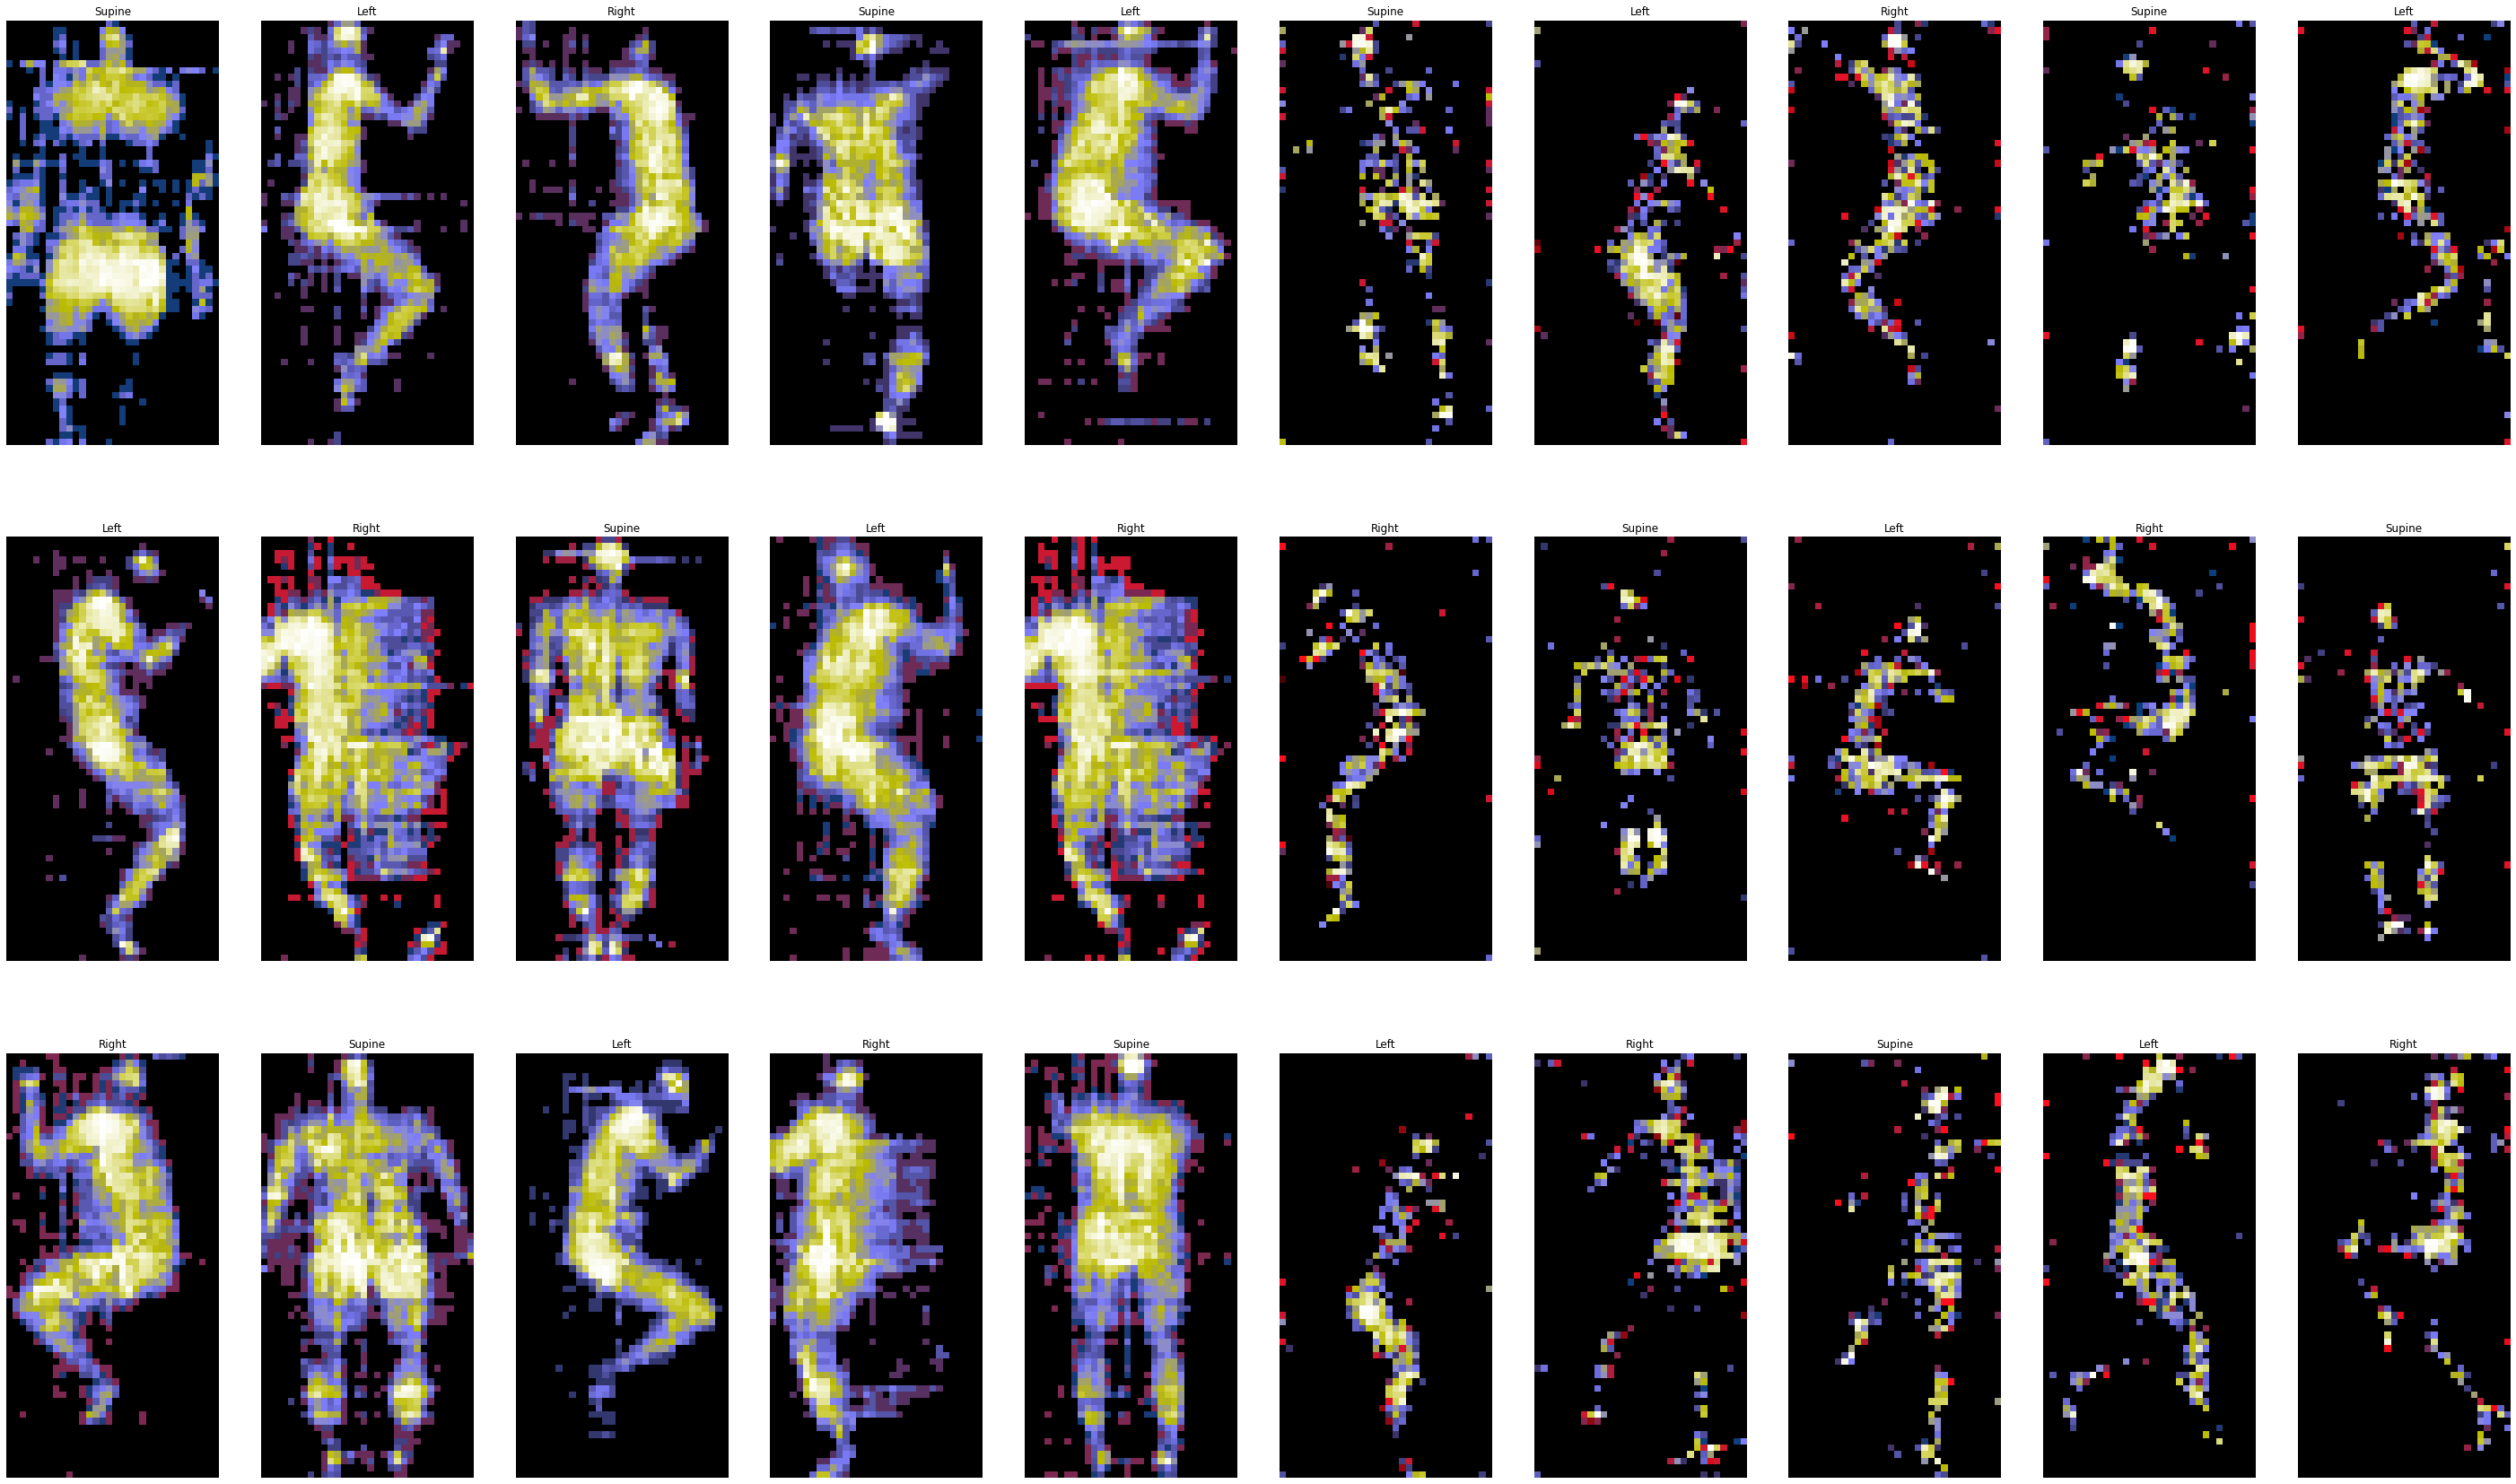

In [6]:
normalizations = [
    Resize((32, 64)),
    Standardize(),
    NormalizeValues(),
    EqualizeHist(),
]


plot_samples(
    samples,
    ncols=10,
    transform=torchvision.transforms.Compose(
        normalizations
    ),
)


## Transformation


### Agressive Thresholding

Notes

- Hier sieht man, dass das Thresholding bei Physionet zwar Verbindungen zerstört, aber die grobe Körperform nicht "zu sehr" verfälscht
  - Bei den slp bildern sind allerdings große grobe Lücken innerhalb der Körper entstanden, was nicht gut ist (wie man in den ergebnissen später sehen wird -> Einfluss Evaluieren)
  - Wir wollen ja noise entfernen ohne die eigenlichen Daten zu zerstören/verändern (Referenz zu Definition Preprocessing bzw Noise removal abschnitt)
- Does Preprocessing on the original size of slp yield better results?


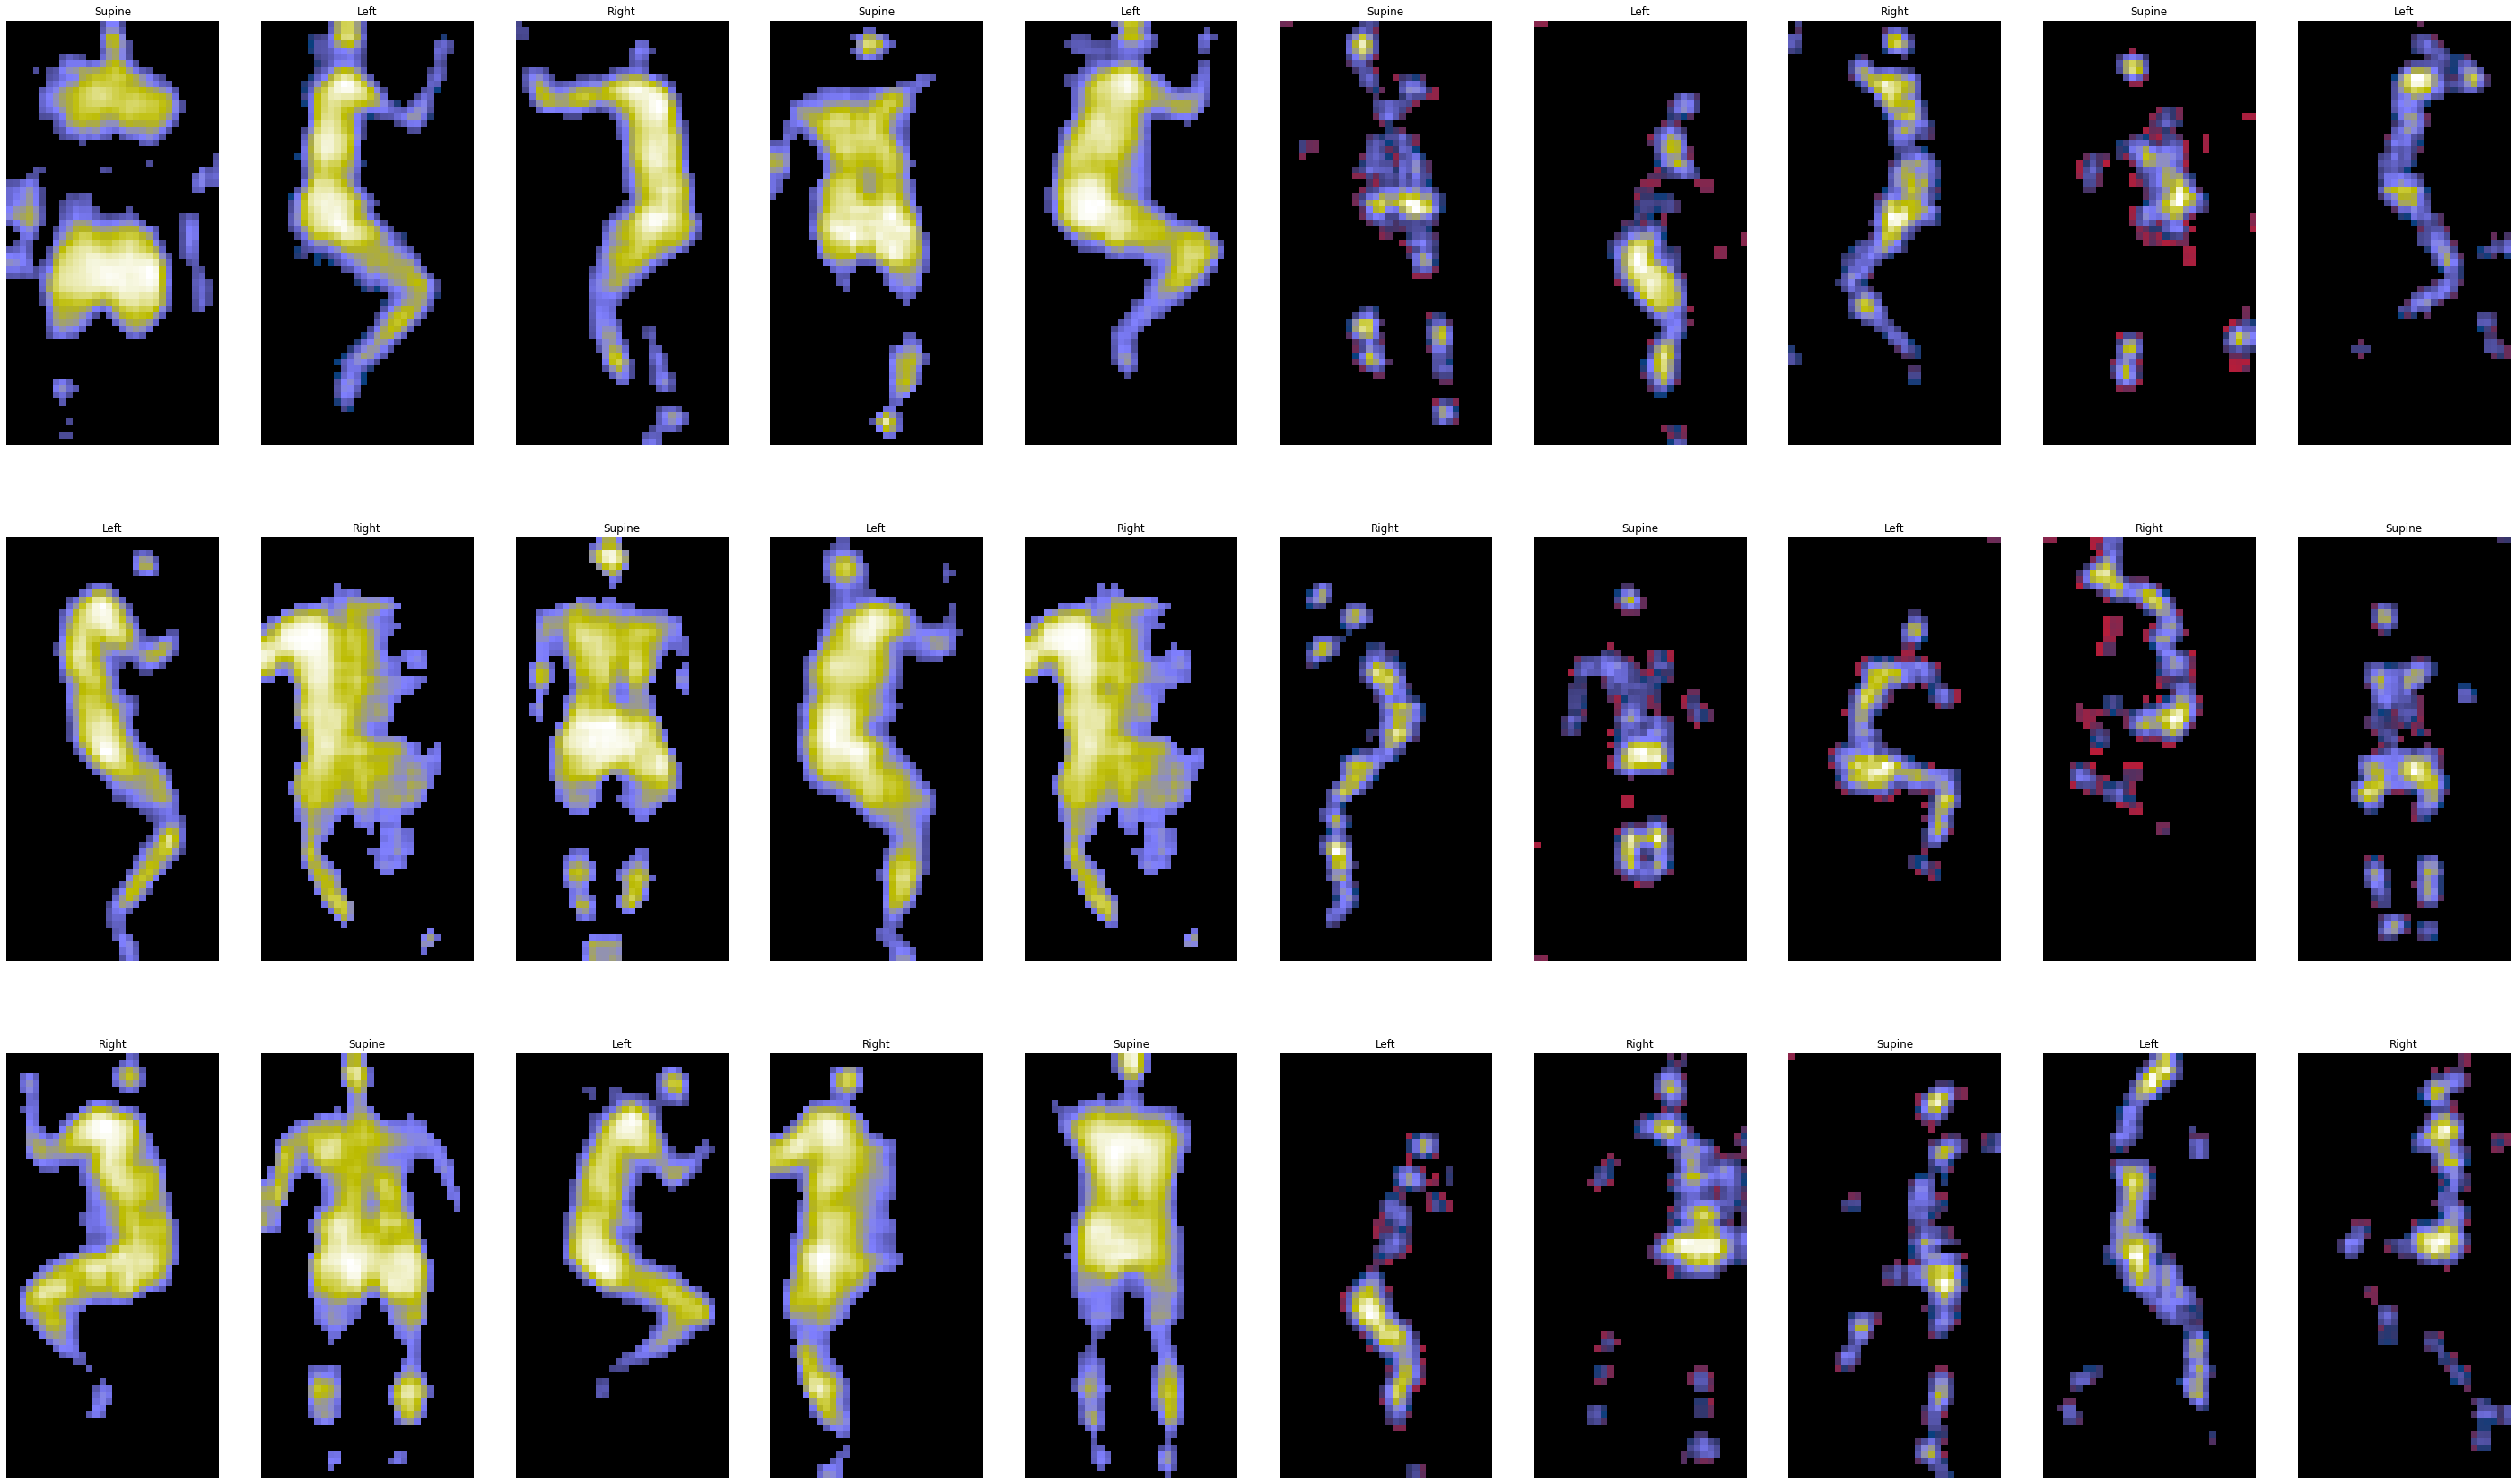

In [7]:
plot_samples(
    samples,
    ncols=10,
    transform=torchvision.transforms.Compose(
        [
            *normalizations,
            Blur((3, 3)),
            Threshold(lambda img: np.median(img[img > 0.0])),
        ]
    ),
)


### Sobel


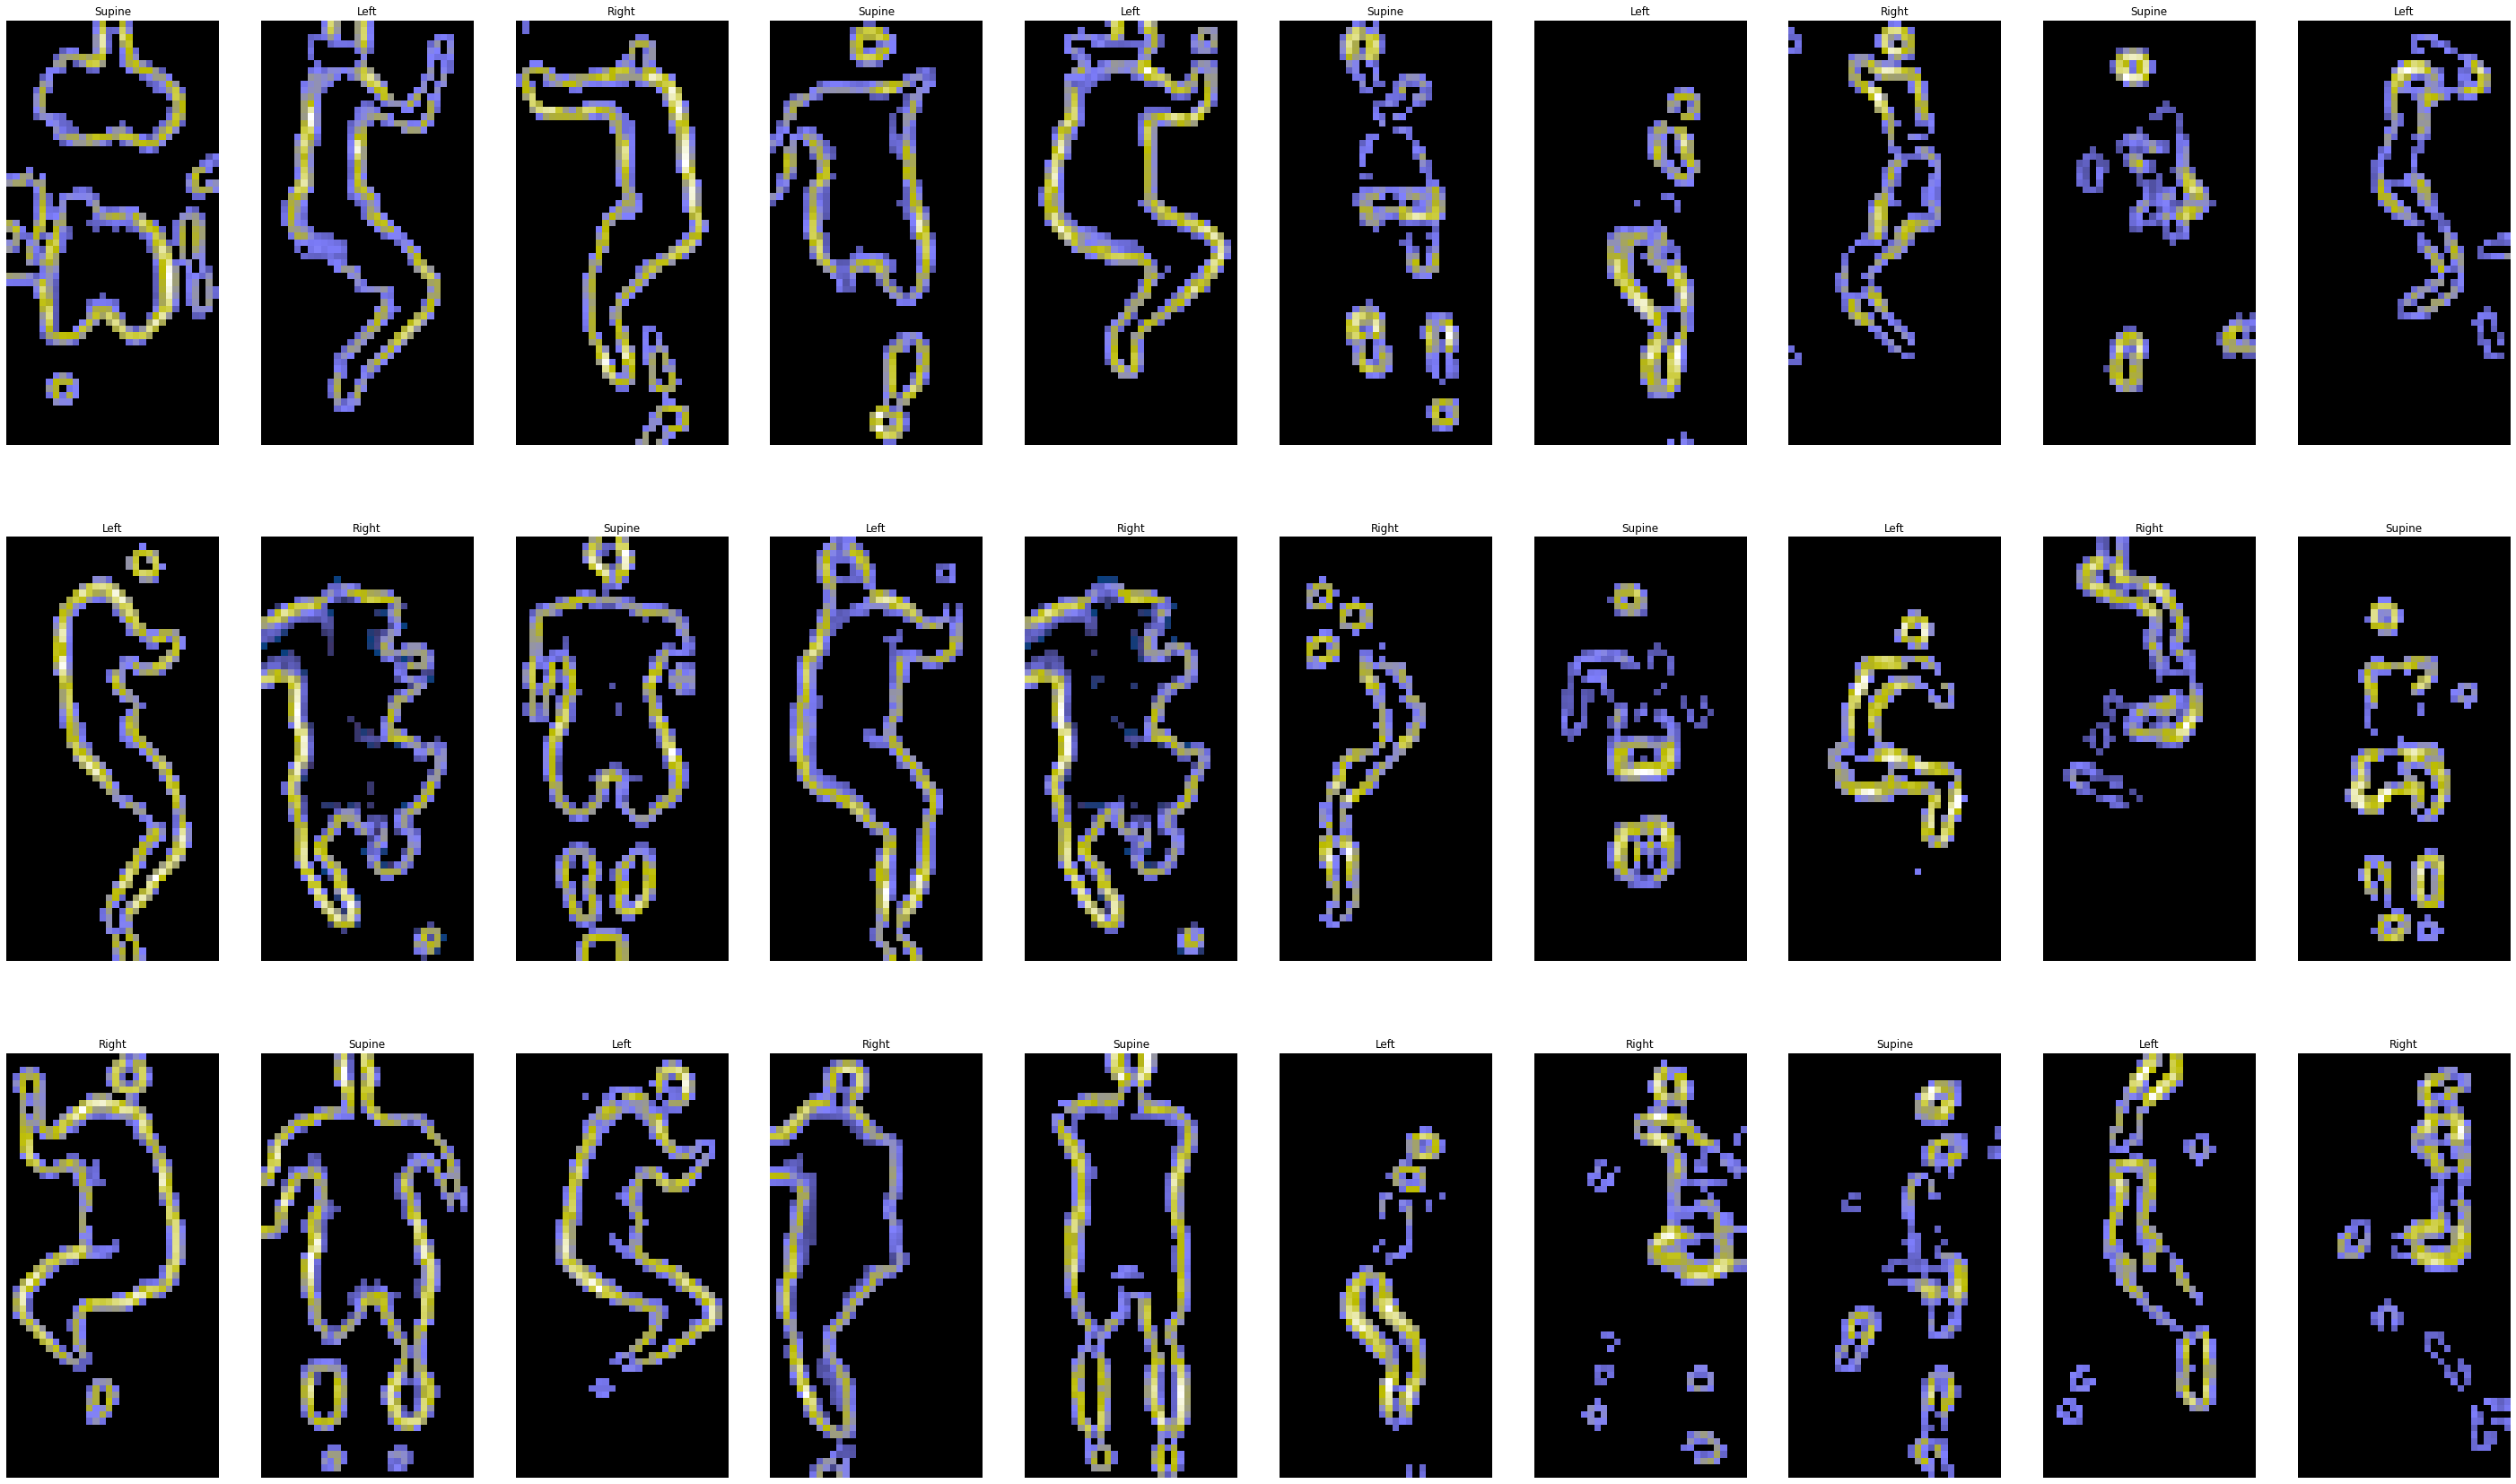

In [8]:
plot_samples(
    samples,
    ncols=10,
    transform=torchvision.transforms.Compose(
        [
            *normalizations,
            Blur((3, 3)),
            Threshold(lambda img: np.median(img[img > 0.0])),
            Sobel(),
            Threshold(lambda img: np.median(img[img > 0.0])),
            # Blur((3, 3)),
            # Close((2, 2), ktype=cv2.MORPH_CROSS, iterations=2),
            # Threshold(lambda img: np.median(img[img > 0.0])),
            # Laplace(),
        ]
    ),
)


### Laplace

Hintergrundhelligkeit verändert sich irgendwie...


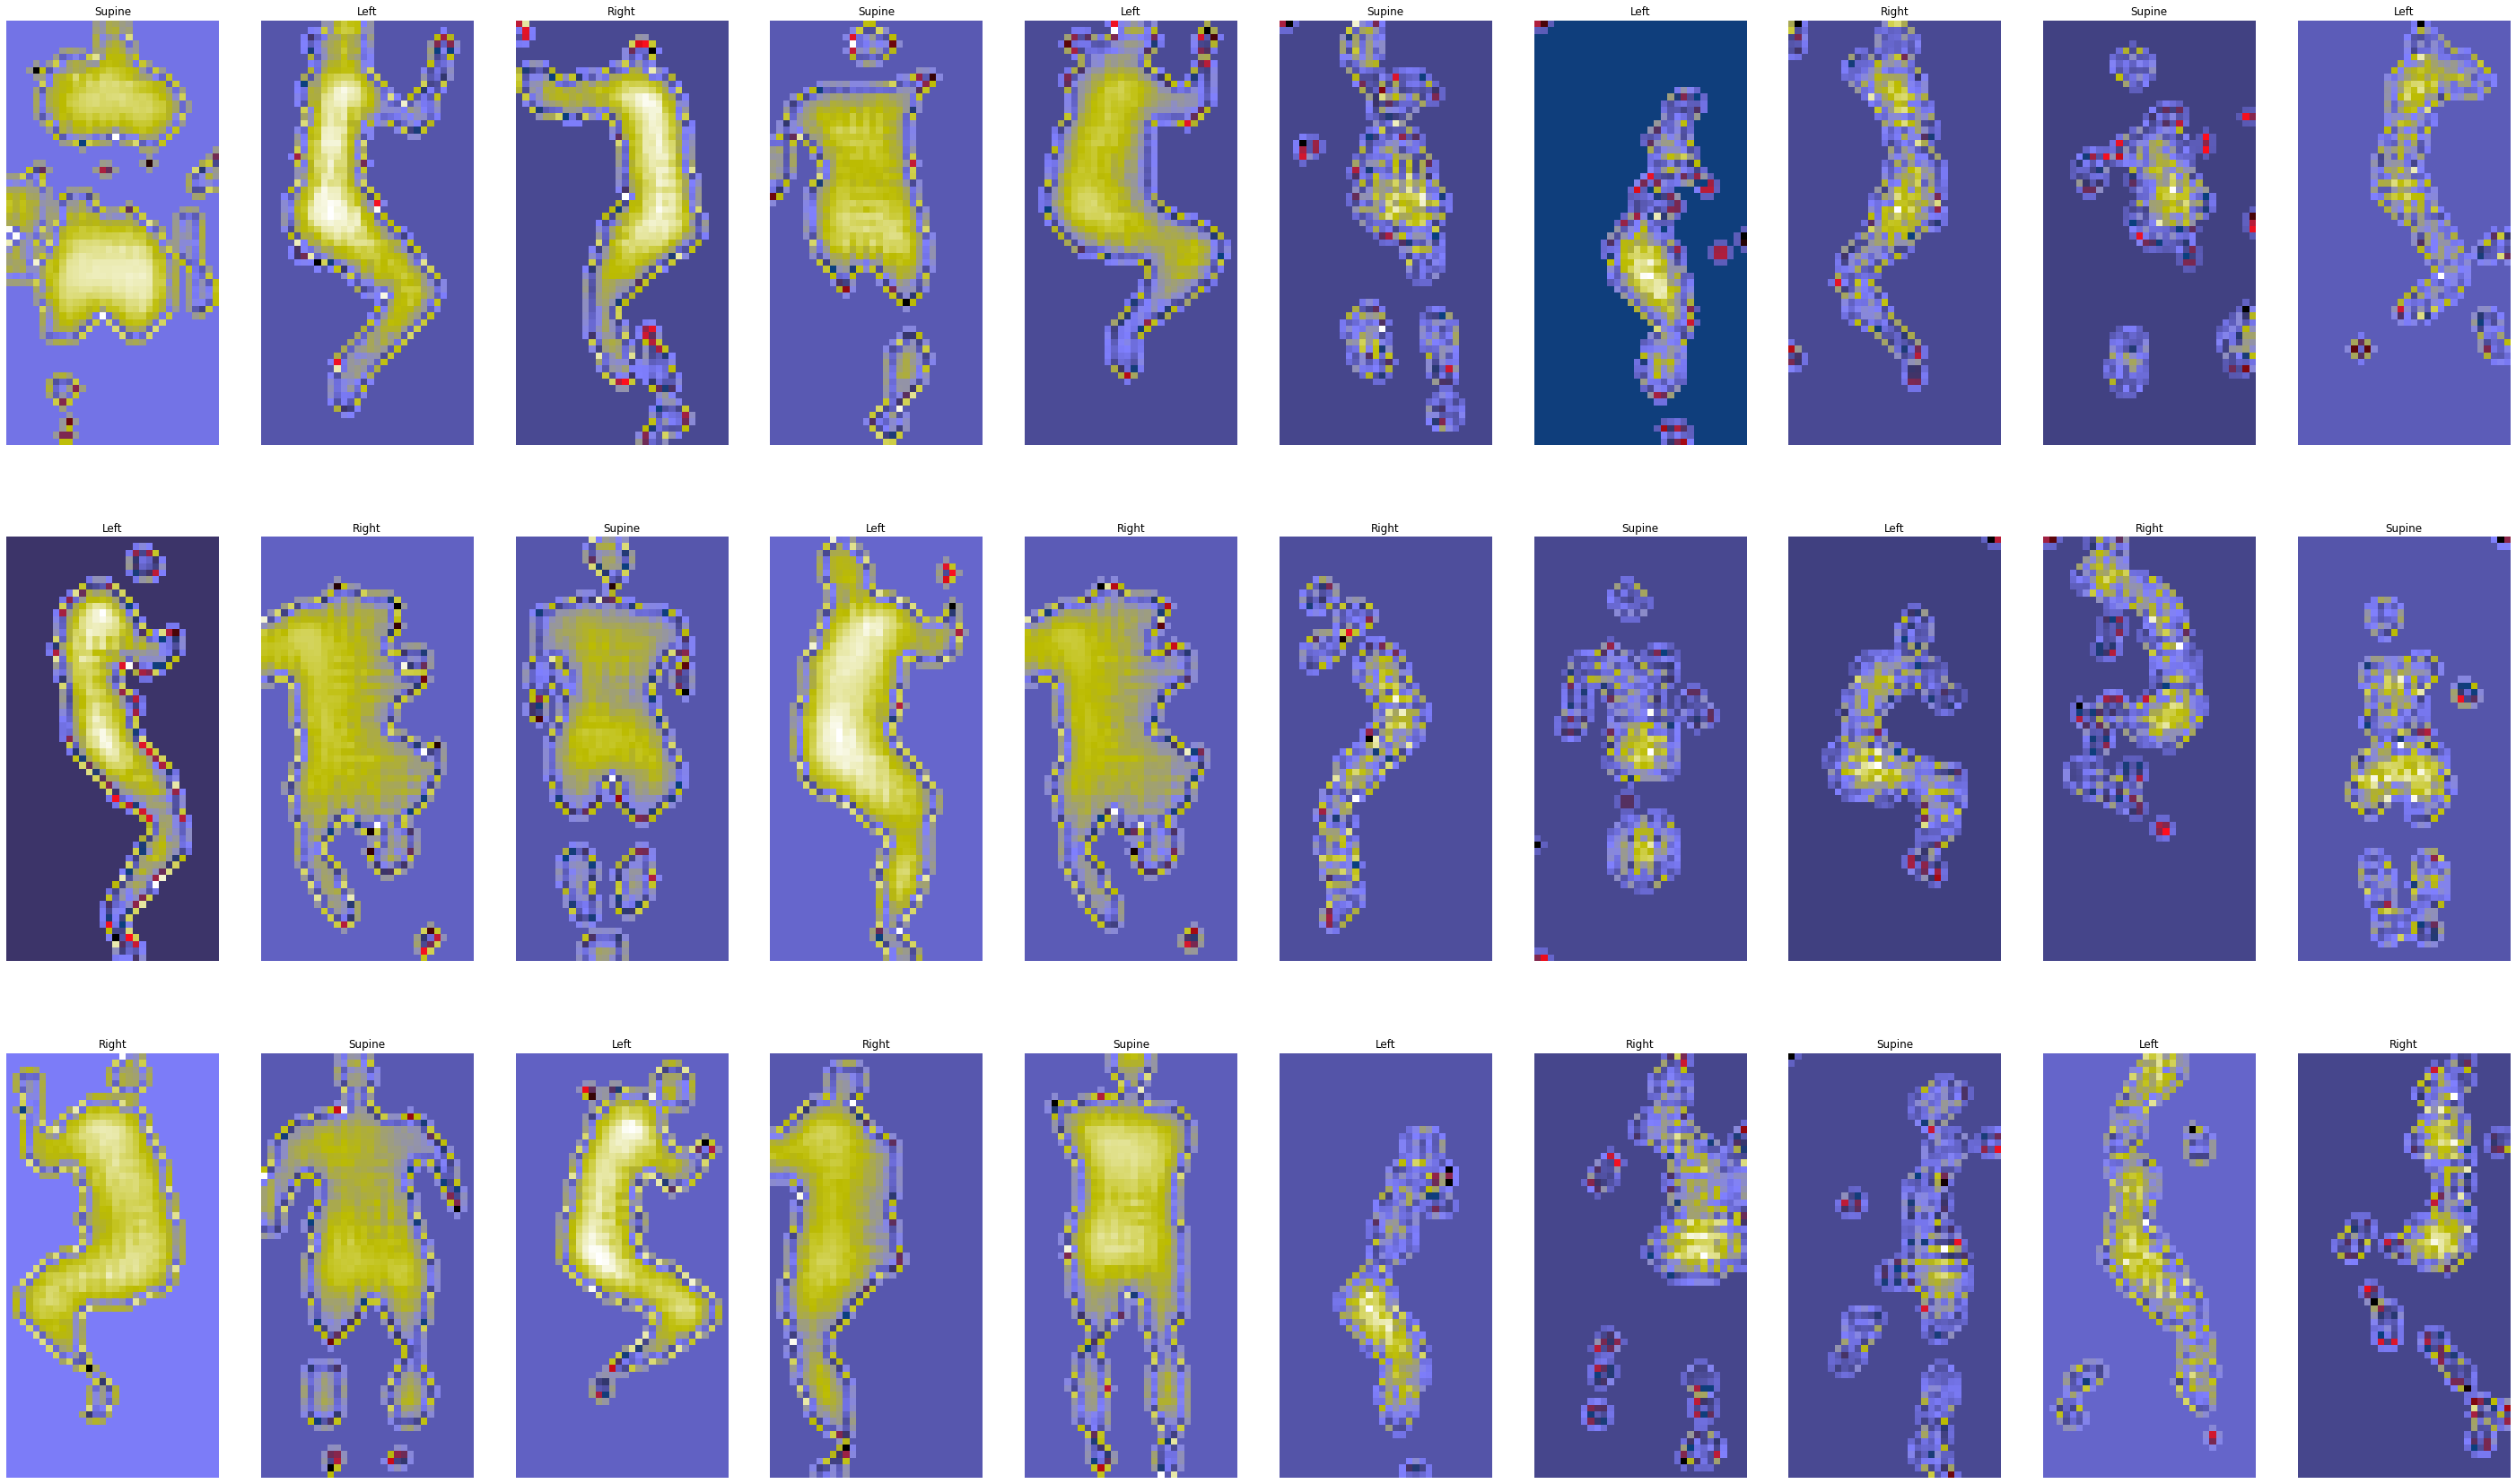

In [9]:
plot_samples(
    samples,
    ncols=10,
    transform=torchvision.transforms.Compose(
        [
            *normalizations,
            Blur((3, 3)),
            Threshold(lambda img: np.median(img[img > 0.0])),
            Laplace(),
            # Threshold(lambda img: np.median(img[img > 0.0])),
        ]
    ),
)


### ZCA with basic

- Strategy: find best preprocessing for physionet and slp, and apply zca on the result of that (and maybe do something after that too)


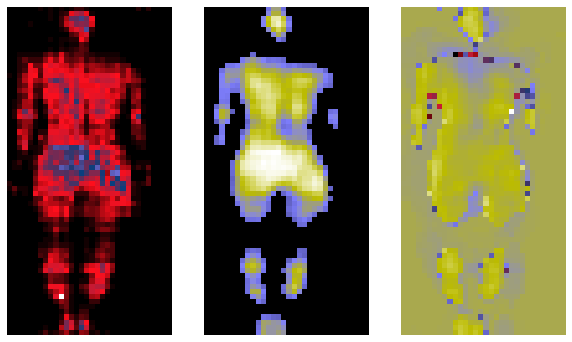

In [49]:
transforms = torchvision.transforms.Compose(basic_transform)

physionet_transformed = np.array(
    list(map(lambda i: i[0], [transforms(sample) for sample in physionet]))
)
zca_transformed_physionet = zca(physionet_transformed, epsilon=0.1)

image_row(physionet[0][0], physionet_transformed[0], zca_transformed_physionet[0])


### Experiments


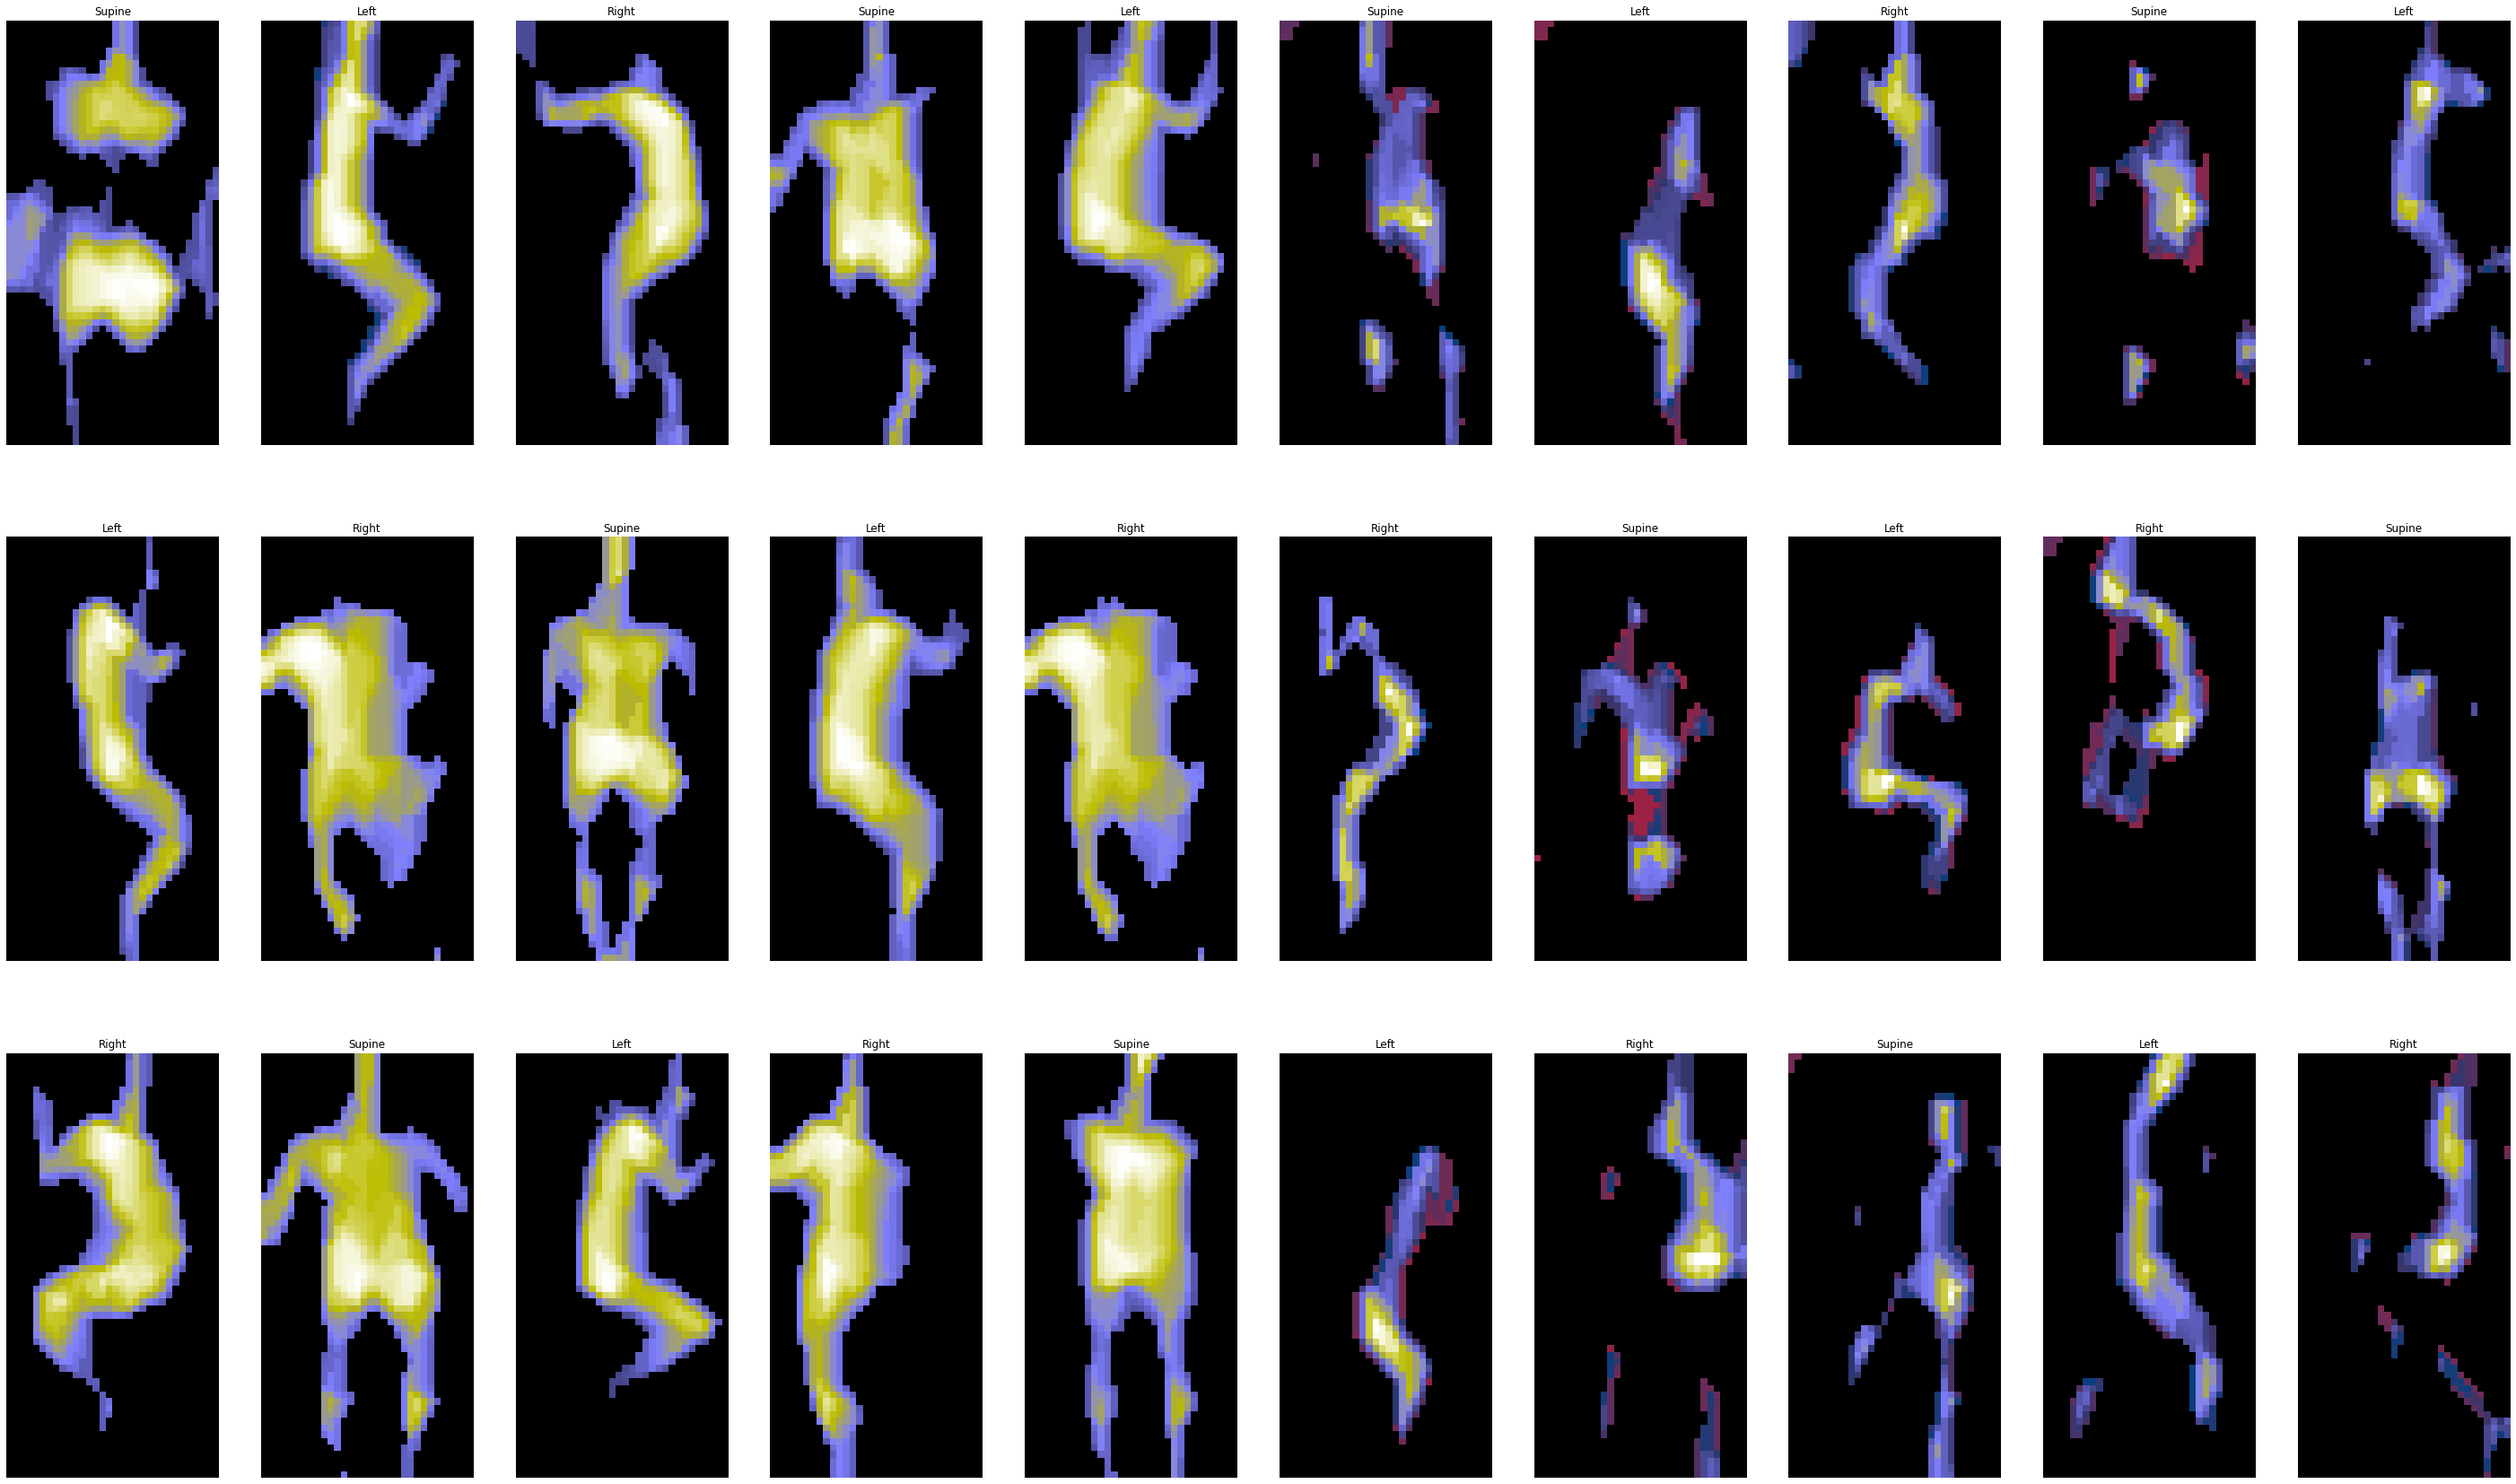

In [10]:
plot_samples(
    samples,
    ncols=10,
    transform=torchvision.transforms.Compose(
        [
            *normalizations,
            Blur((3, 3)),
            Threshold(lambda img: np.median(img[img > 0.0])),
            Close((2, 4), ktype=cv2.MORPH_CROSS, iterations=2),
            # Erode((2,2), ktype=cv2.MORPH_CROSS, iterations=2),
            # Close((3,3), ktype=cv2.MORPH_CROSS, iterations=2),
        ]
    ),
)


### Improve SLP

Blur vor Denoise hilft bei den slp daten mega krass, weil die Rohdaten so lose verstreut sind


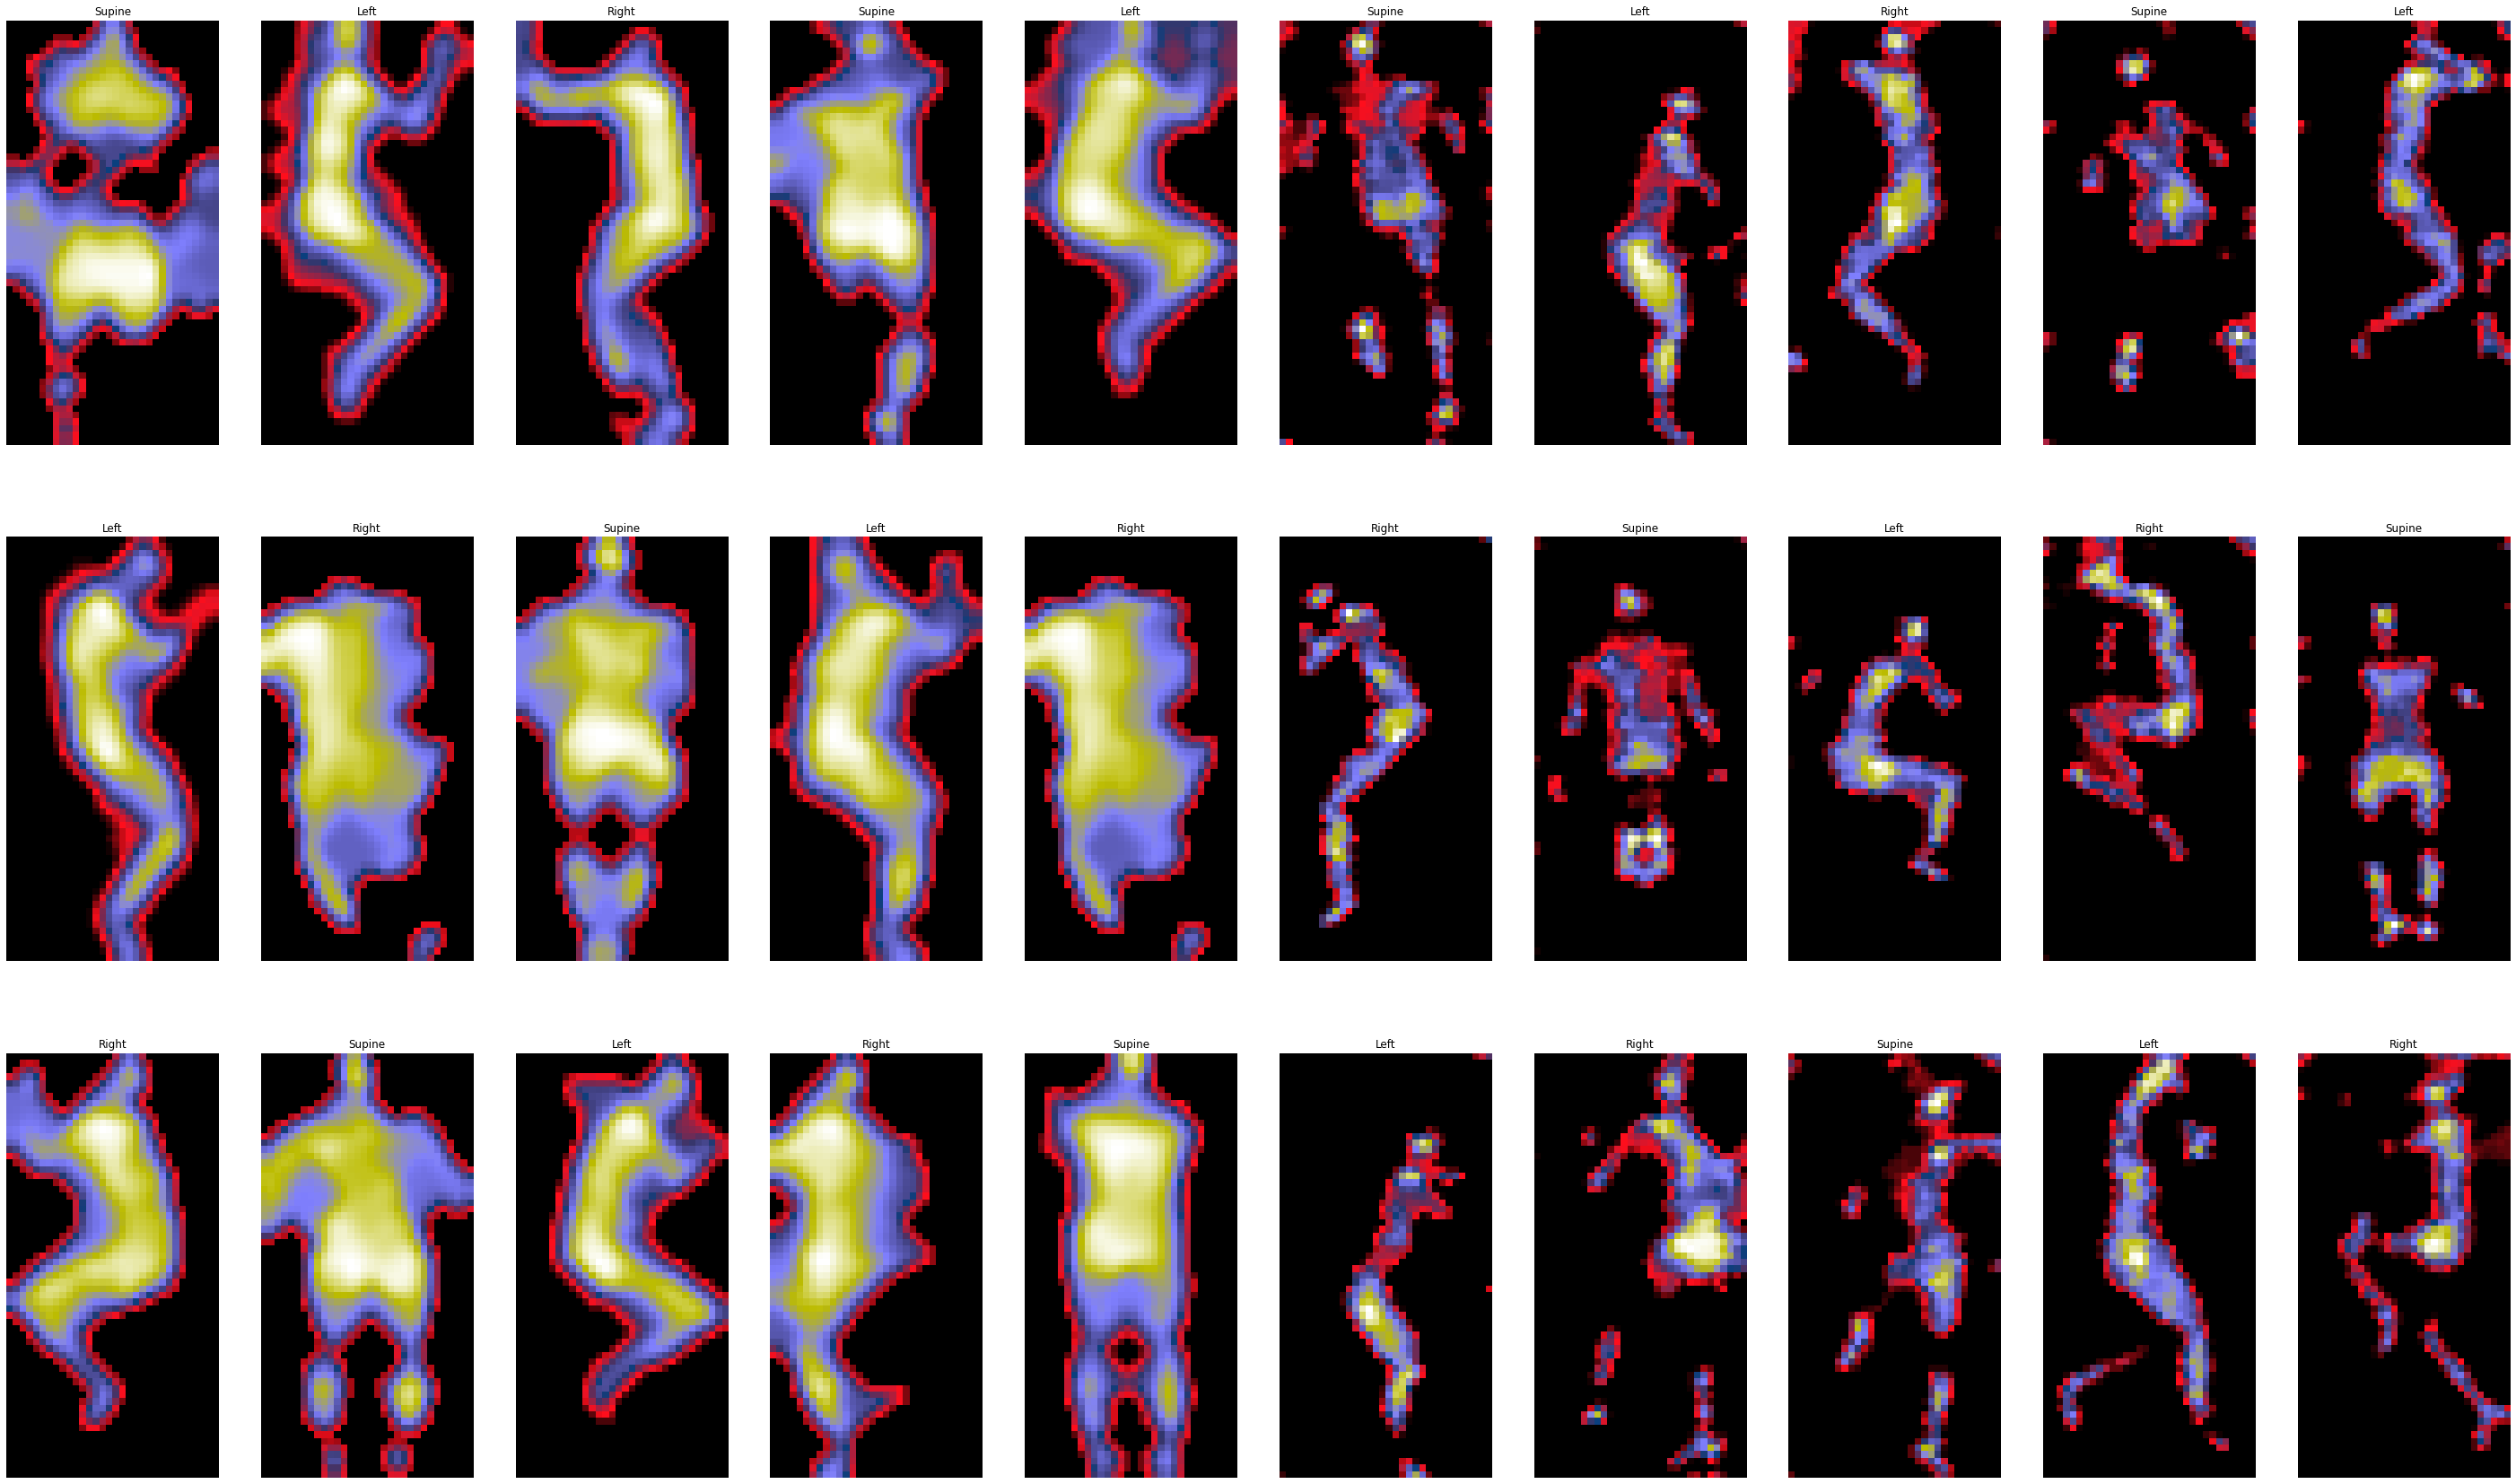

In [11]:
plot_samples(
    samples,
    ncols=10,
    transform=torchvision.transforms.Compose(
        [
            # Resize((32, 64)),
            Standardize(),
            NormalizeValues(),
            EqualizeHist(),
            Blur((3, 3)),
            Denoise(),
            Threshold(lambda img: np.median(img[img > 0.0])),
            Close((3, 3), ktype=cv2.MORPH_CROSS, iterations=3),
            # Close((3,3), ktype=cv2.MORPH_CROSS, iterations=3),
            Blur((3, 3)),
            Resize((32, 64)),
            # Threshold(lambda img: np.median(img)),
            # Close((2, 4), ktype=cv2.MORPH_CROSS, iterations=2),
            # Erode((2,2), ktype=cv2.MORPH_CROSS, iterations=2),
            # Close((3,3), ktype=cv2.MORPH_CROSS, iterations=2),
        ]
    ),
)


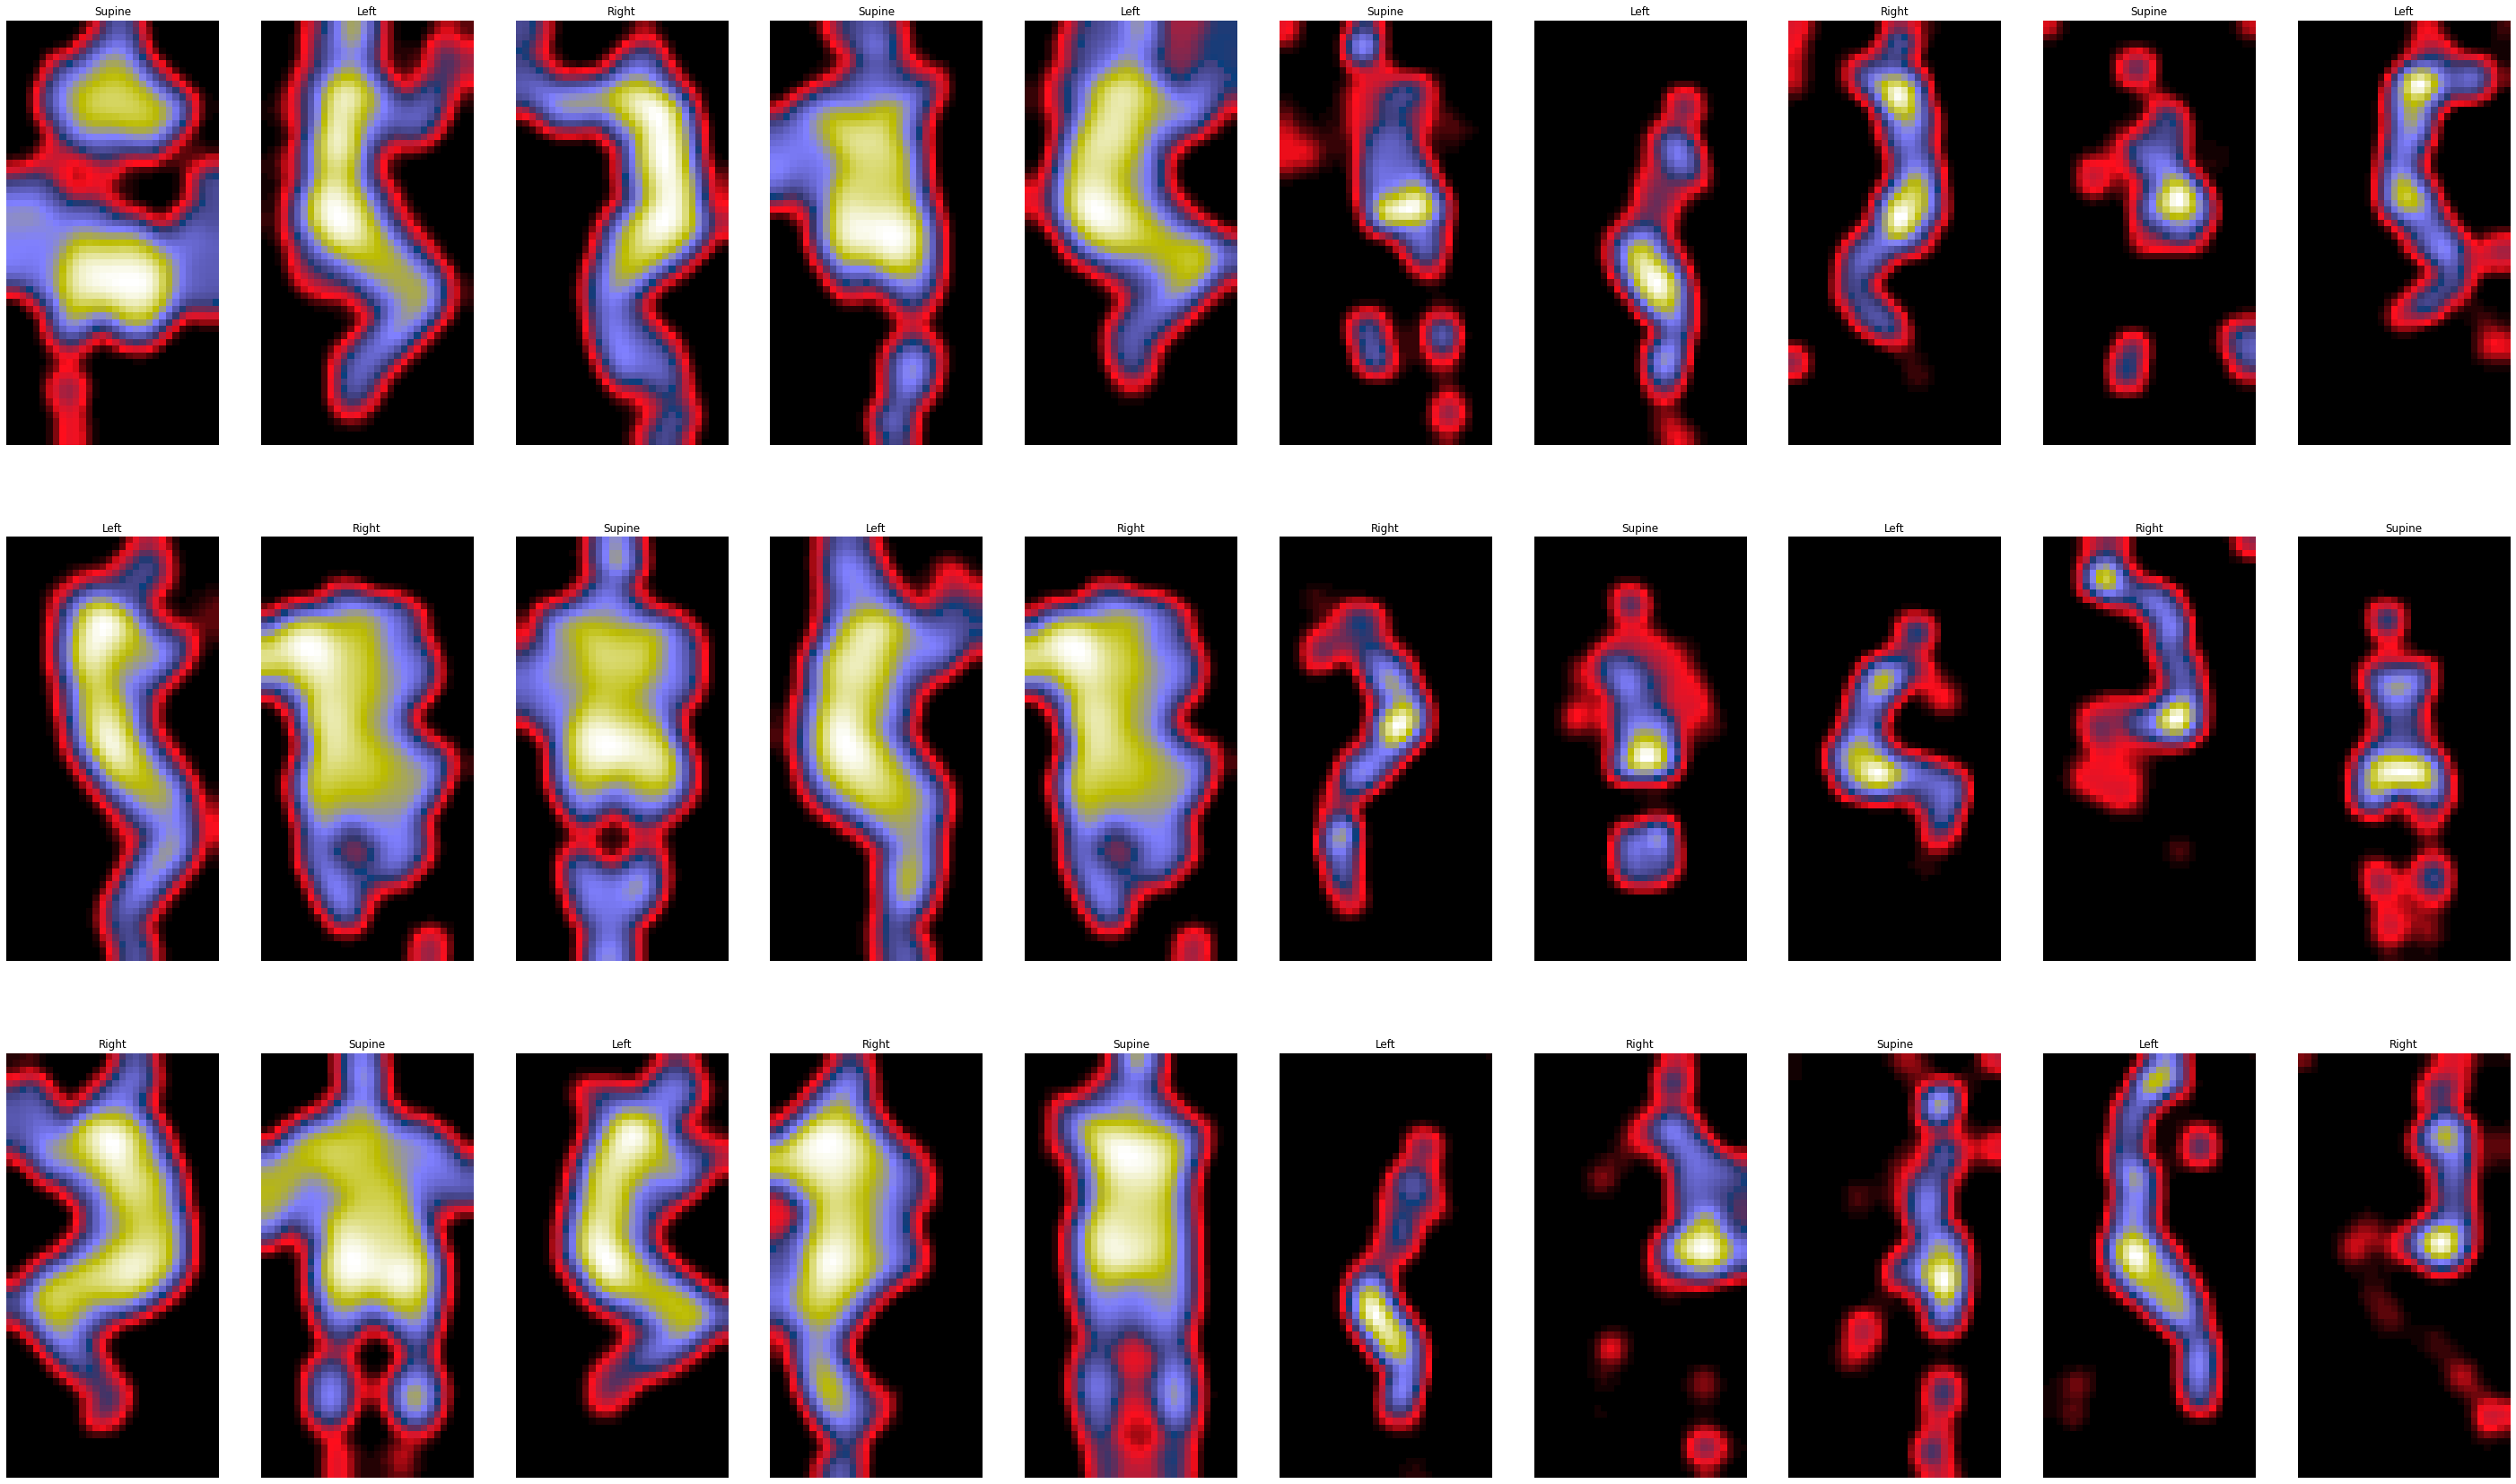

In [12]:
plot_samples(
    samples,
    ncols=10,
    transform=torchvision.transforms.Compose(
        [
            Standardize(),
            NormalizeValues(),
            EqualizeHist(),
            Blur((3, 3)),
            Denoise(),
            Threshold(lambda img: np.median(img[img > 0.0])),
            Close((6, 6), ktype=cv2.MORPH_CROSS, iterations=1),
            # Close((3,3), ktype=cv2.MORPH_CROSS, iterations=3),
            Blur((3, 3)),
            Resize((32, 64), cv2.INTER_LINEAR),
            Open(),
            Blur((3, 3)),
            # Threshold(lambda img: np.median(img[img > 0.0])),
            # Threshold(lambda img: np.median(img)),
            # Close((2, 4), ktype=cv2.MORPH_CROSS, iterations=2),
            # Erode((2,2), ktype=cv2.MORPH_CROSS, iterations=2),
            Close((3,3), ktype=cv2.MORPH_CROSS, iterations=2),
            # EqualizeHist(),
            Blur((3, 3)),
        ]
    ),
)


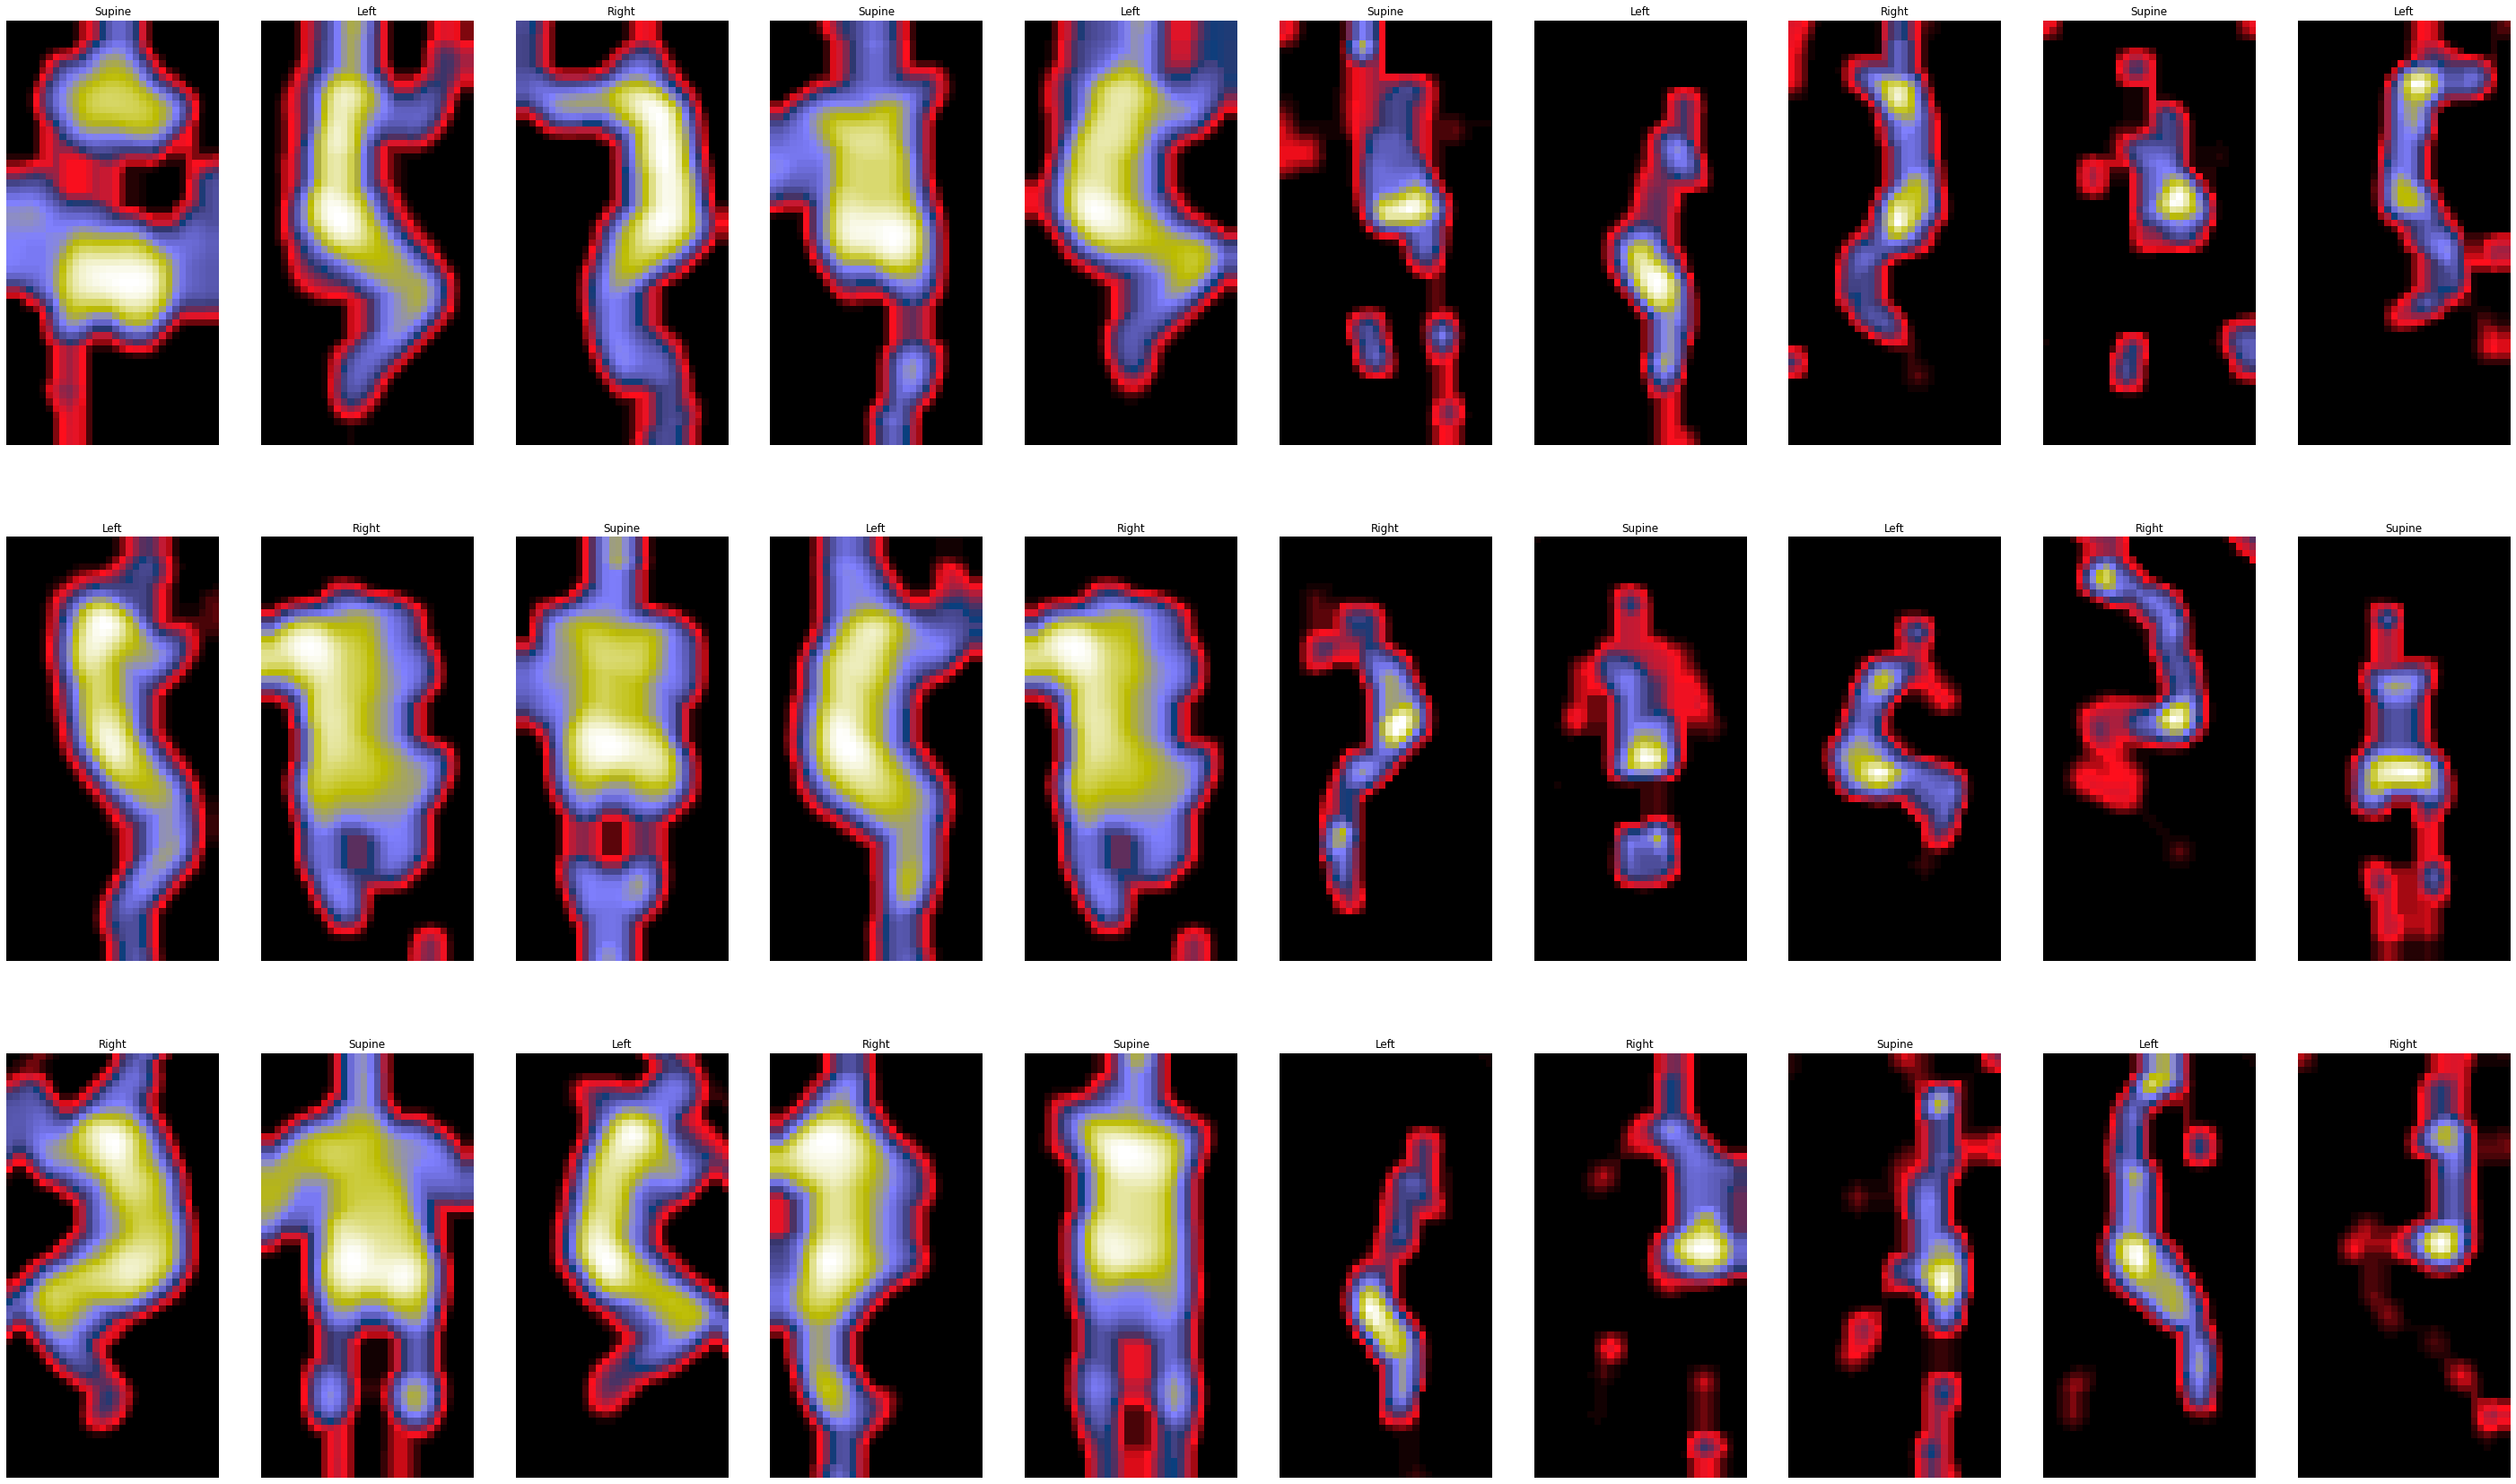

In [13]:
plot_samples(
    samples,
    ncols=10,
    transform=torchvision.transforms.Compose(
        [
            Standardize(),
            NormalizeValues(),
            EqualizeHist(),
            Blur((3, 3)),
            Denoise(),
            Threshold(lambda img: np.median(img[img > 0.0])),
            Close((6, 6), ktype=cv2.MORPH_CROSS, iterations=1),
            # Close((3,3), ktype=cv2.MORPH_CROSS, iterations=3),
            Blur((3, 3)),
            Resize((32, 64), cv2.INTER_LINEAR),
            Open(),
            Blur((3, 3)),
            CloseInHoughDirection(debug_lines=False),
            # Threshold(lambda img: np.median(img[img > 0.0])),
            # Threshold(lambda img: np.median(img)),
            # Close((2, 4), ktype=cv2.MORPH_CROSS, iterations=2),
            # Erode((2,2), ktype=cv2.MORPH_CROSS, iterations=2),
            # Close((3,3), ktype=cv2.MORPH_CROSS, iterations=2),
        ]
    ),
)


### Crimmins


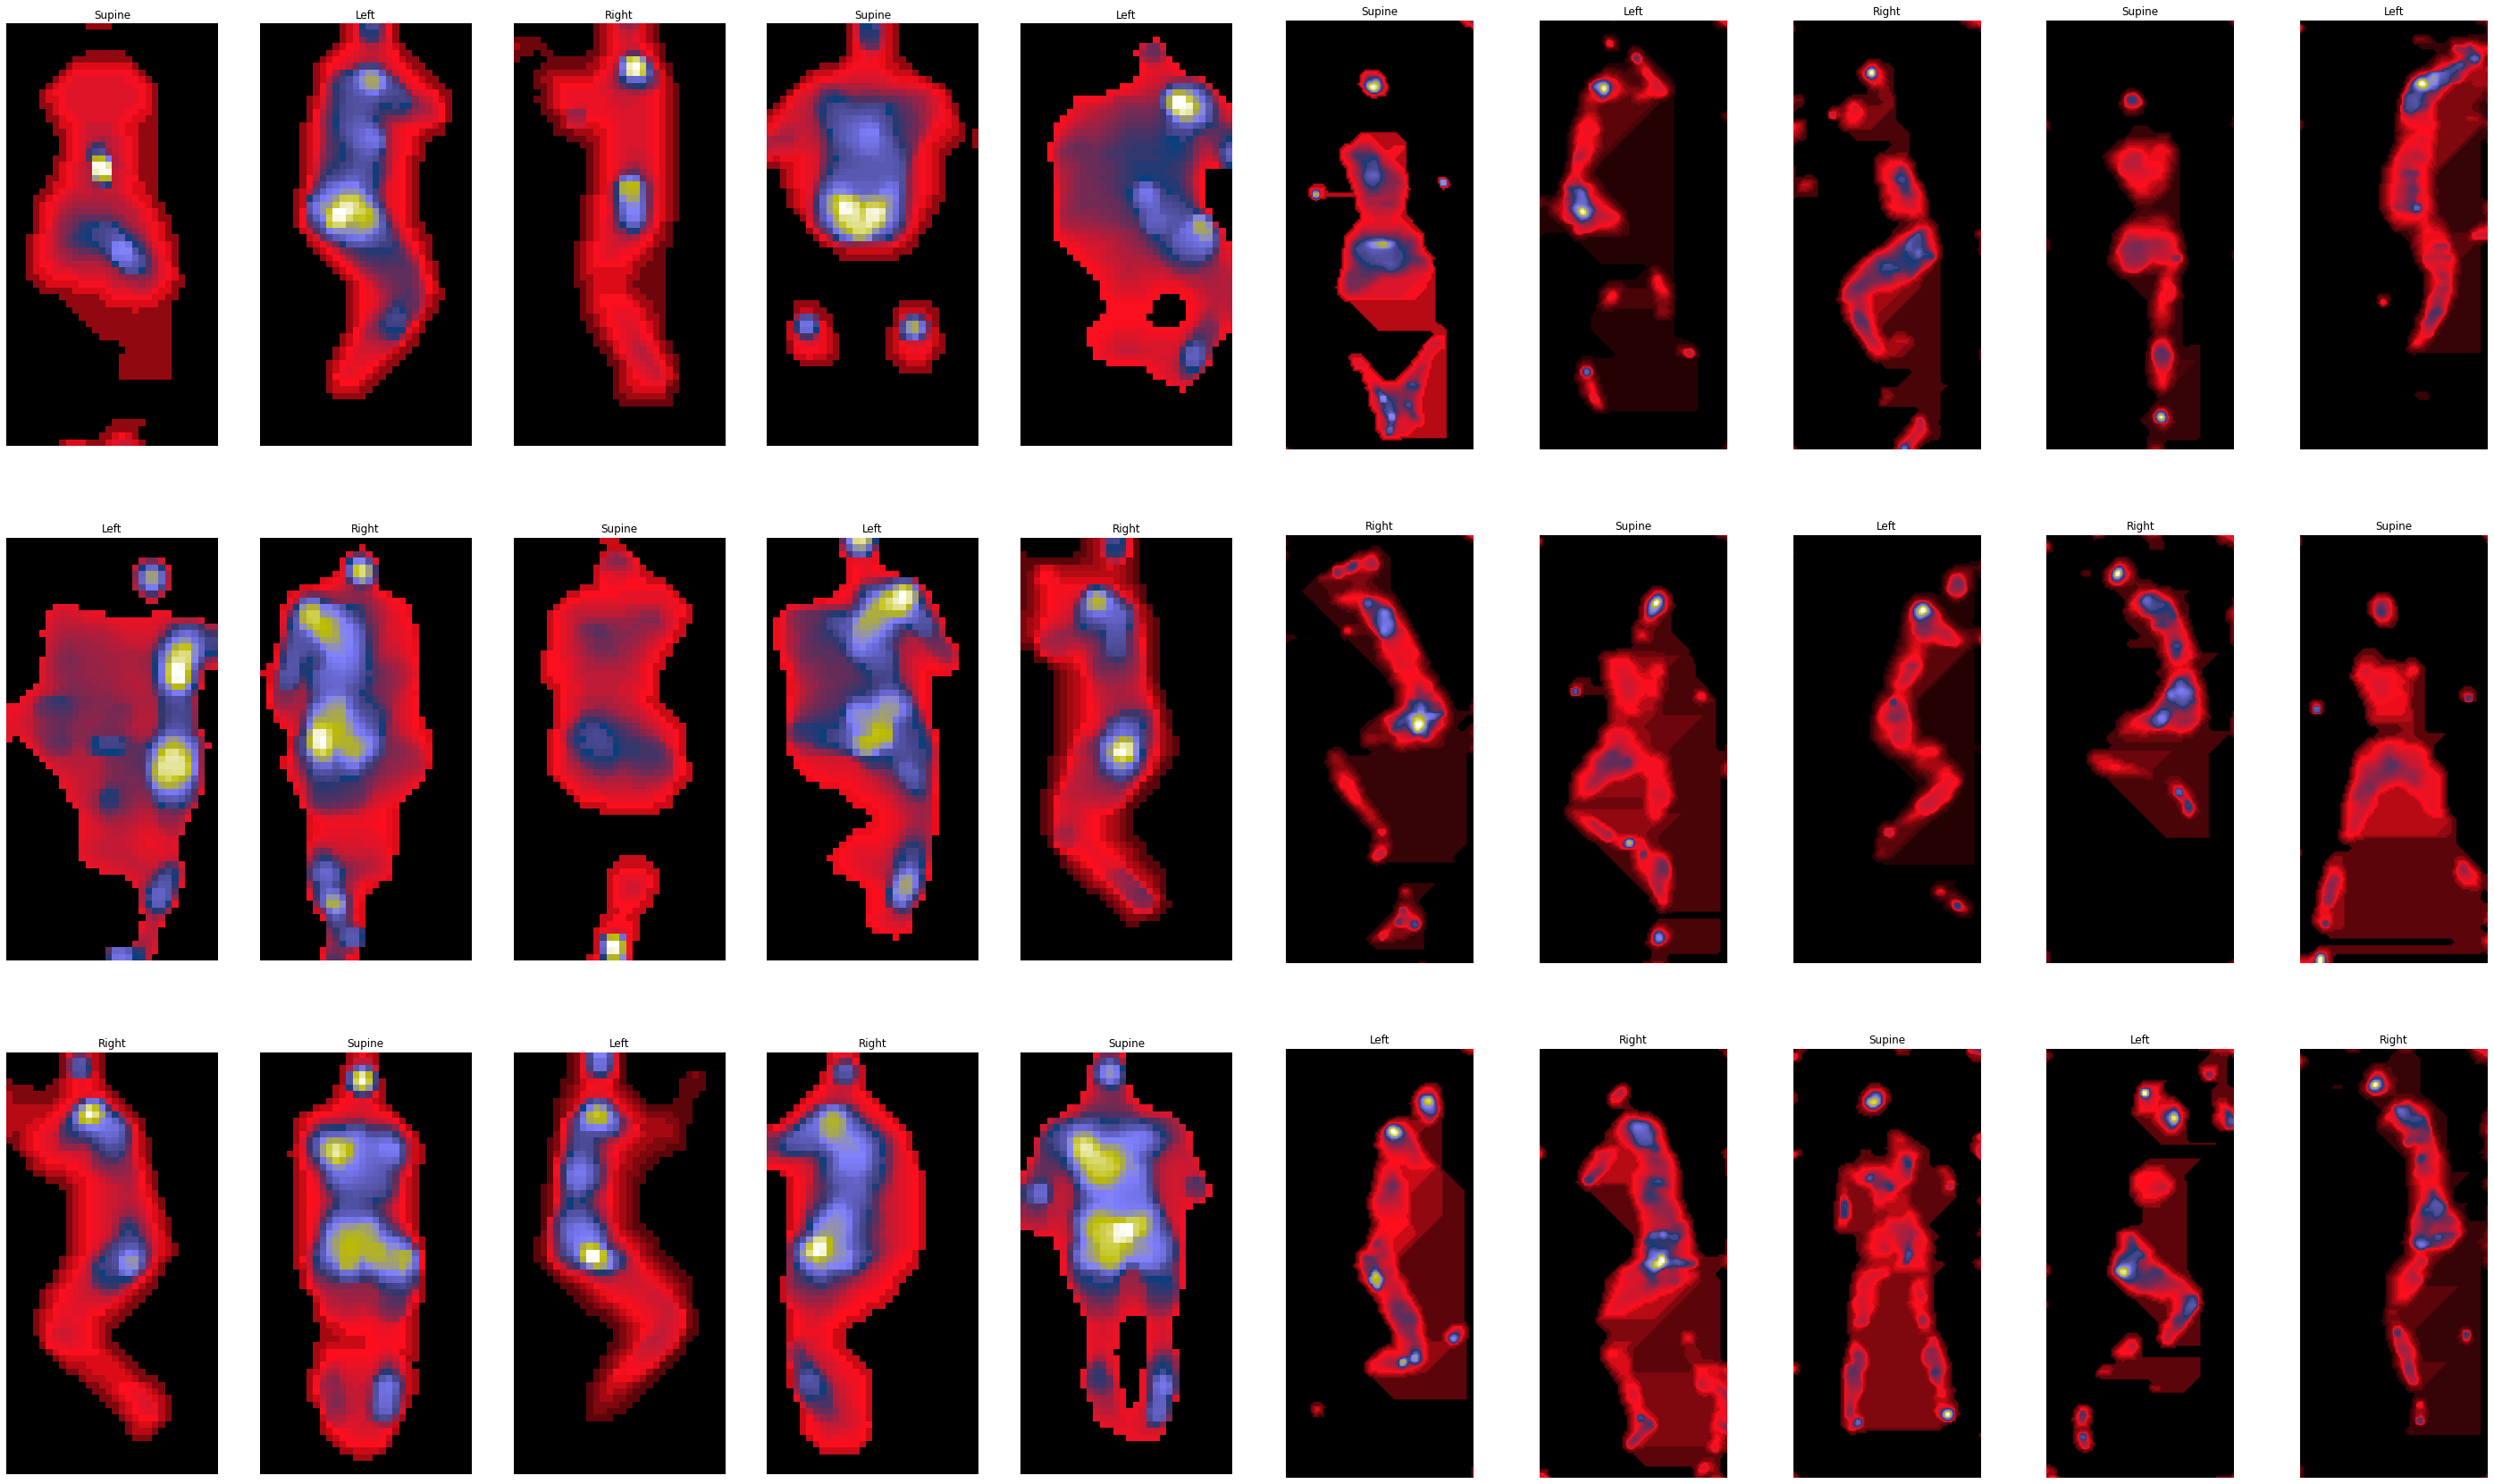

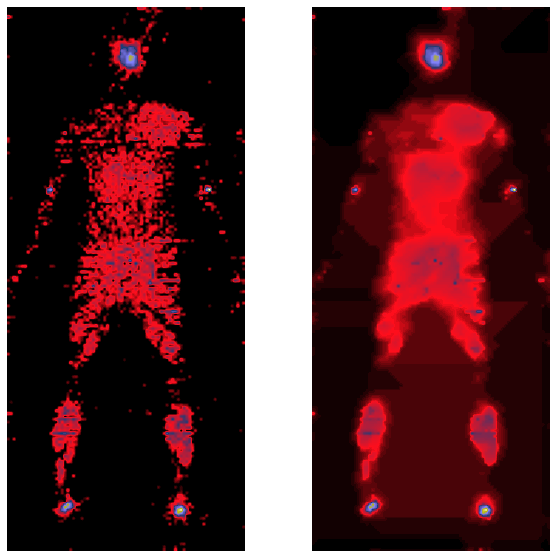

In [76]:
plot_samples(
    samples,
    ncols=10,
    transform=torchvision.transforms.Compose(
        [
            # Resize((32, 64), cv2.INTER_LINEAR),
            # Normalize(),
            # EqualizeHist(),
            Blur((3, 3)),
            Crimmins(),
            Threshold(lambda img: np.median(img)),
        ]
    ),
)
sample = slp[0]
im = crimmins(sample[0])
image_row(sample[0], im)


### Rolling Ball


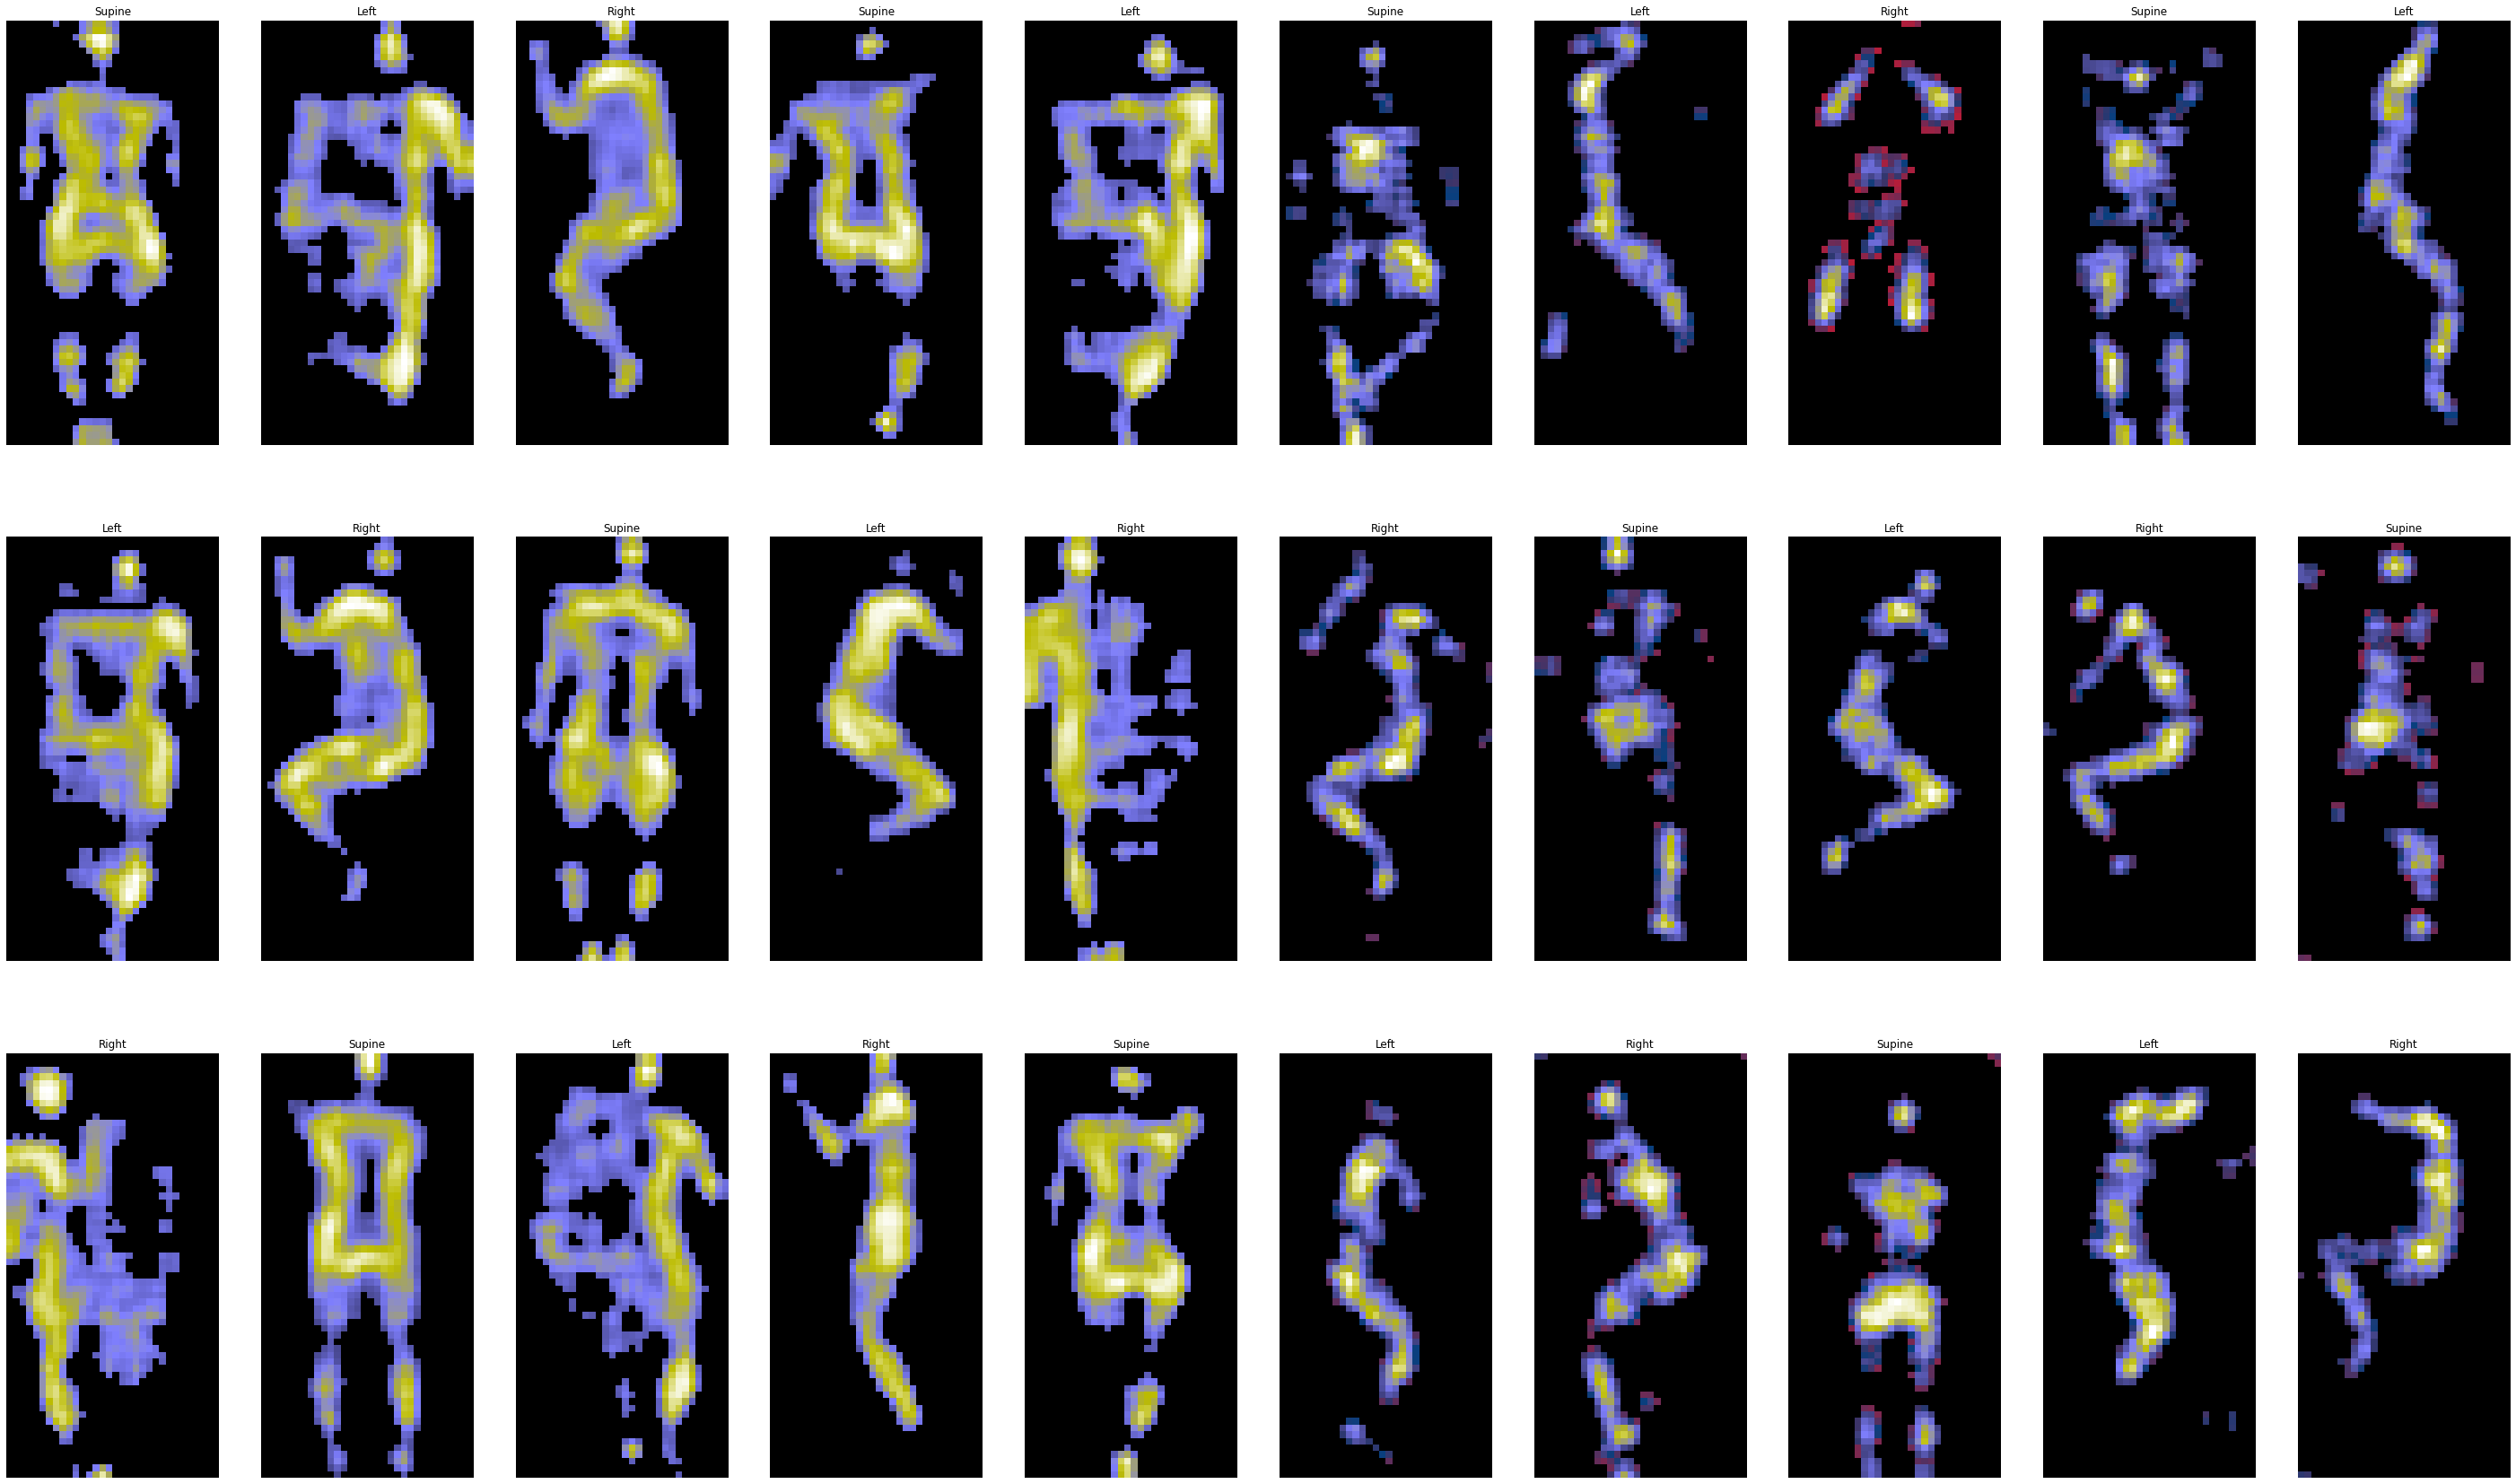

In [67]:
plot_samples(
    samples,
    ncols=10,
    transform=torchvision.transforms.Compose(
        [
            *normalizations,
            RollingBall(radius=5),
            Blur((3, 3)),
            Threshold(lambda img: np.median(img[img > 0.0])),
        ]
    ),
)


### Fourier
- Denoise, um artefakte zu entfernen, die durch den High Pass verstärkt wurden
- Blur vor threshold um einzelne ausreißerpixel auch weg zu thresholden können

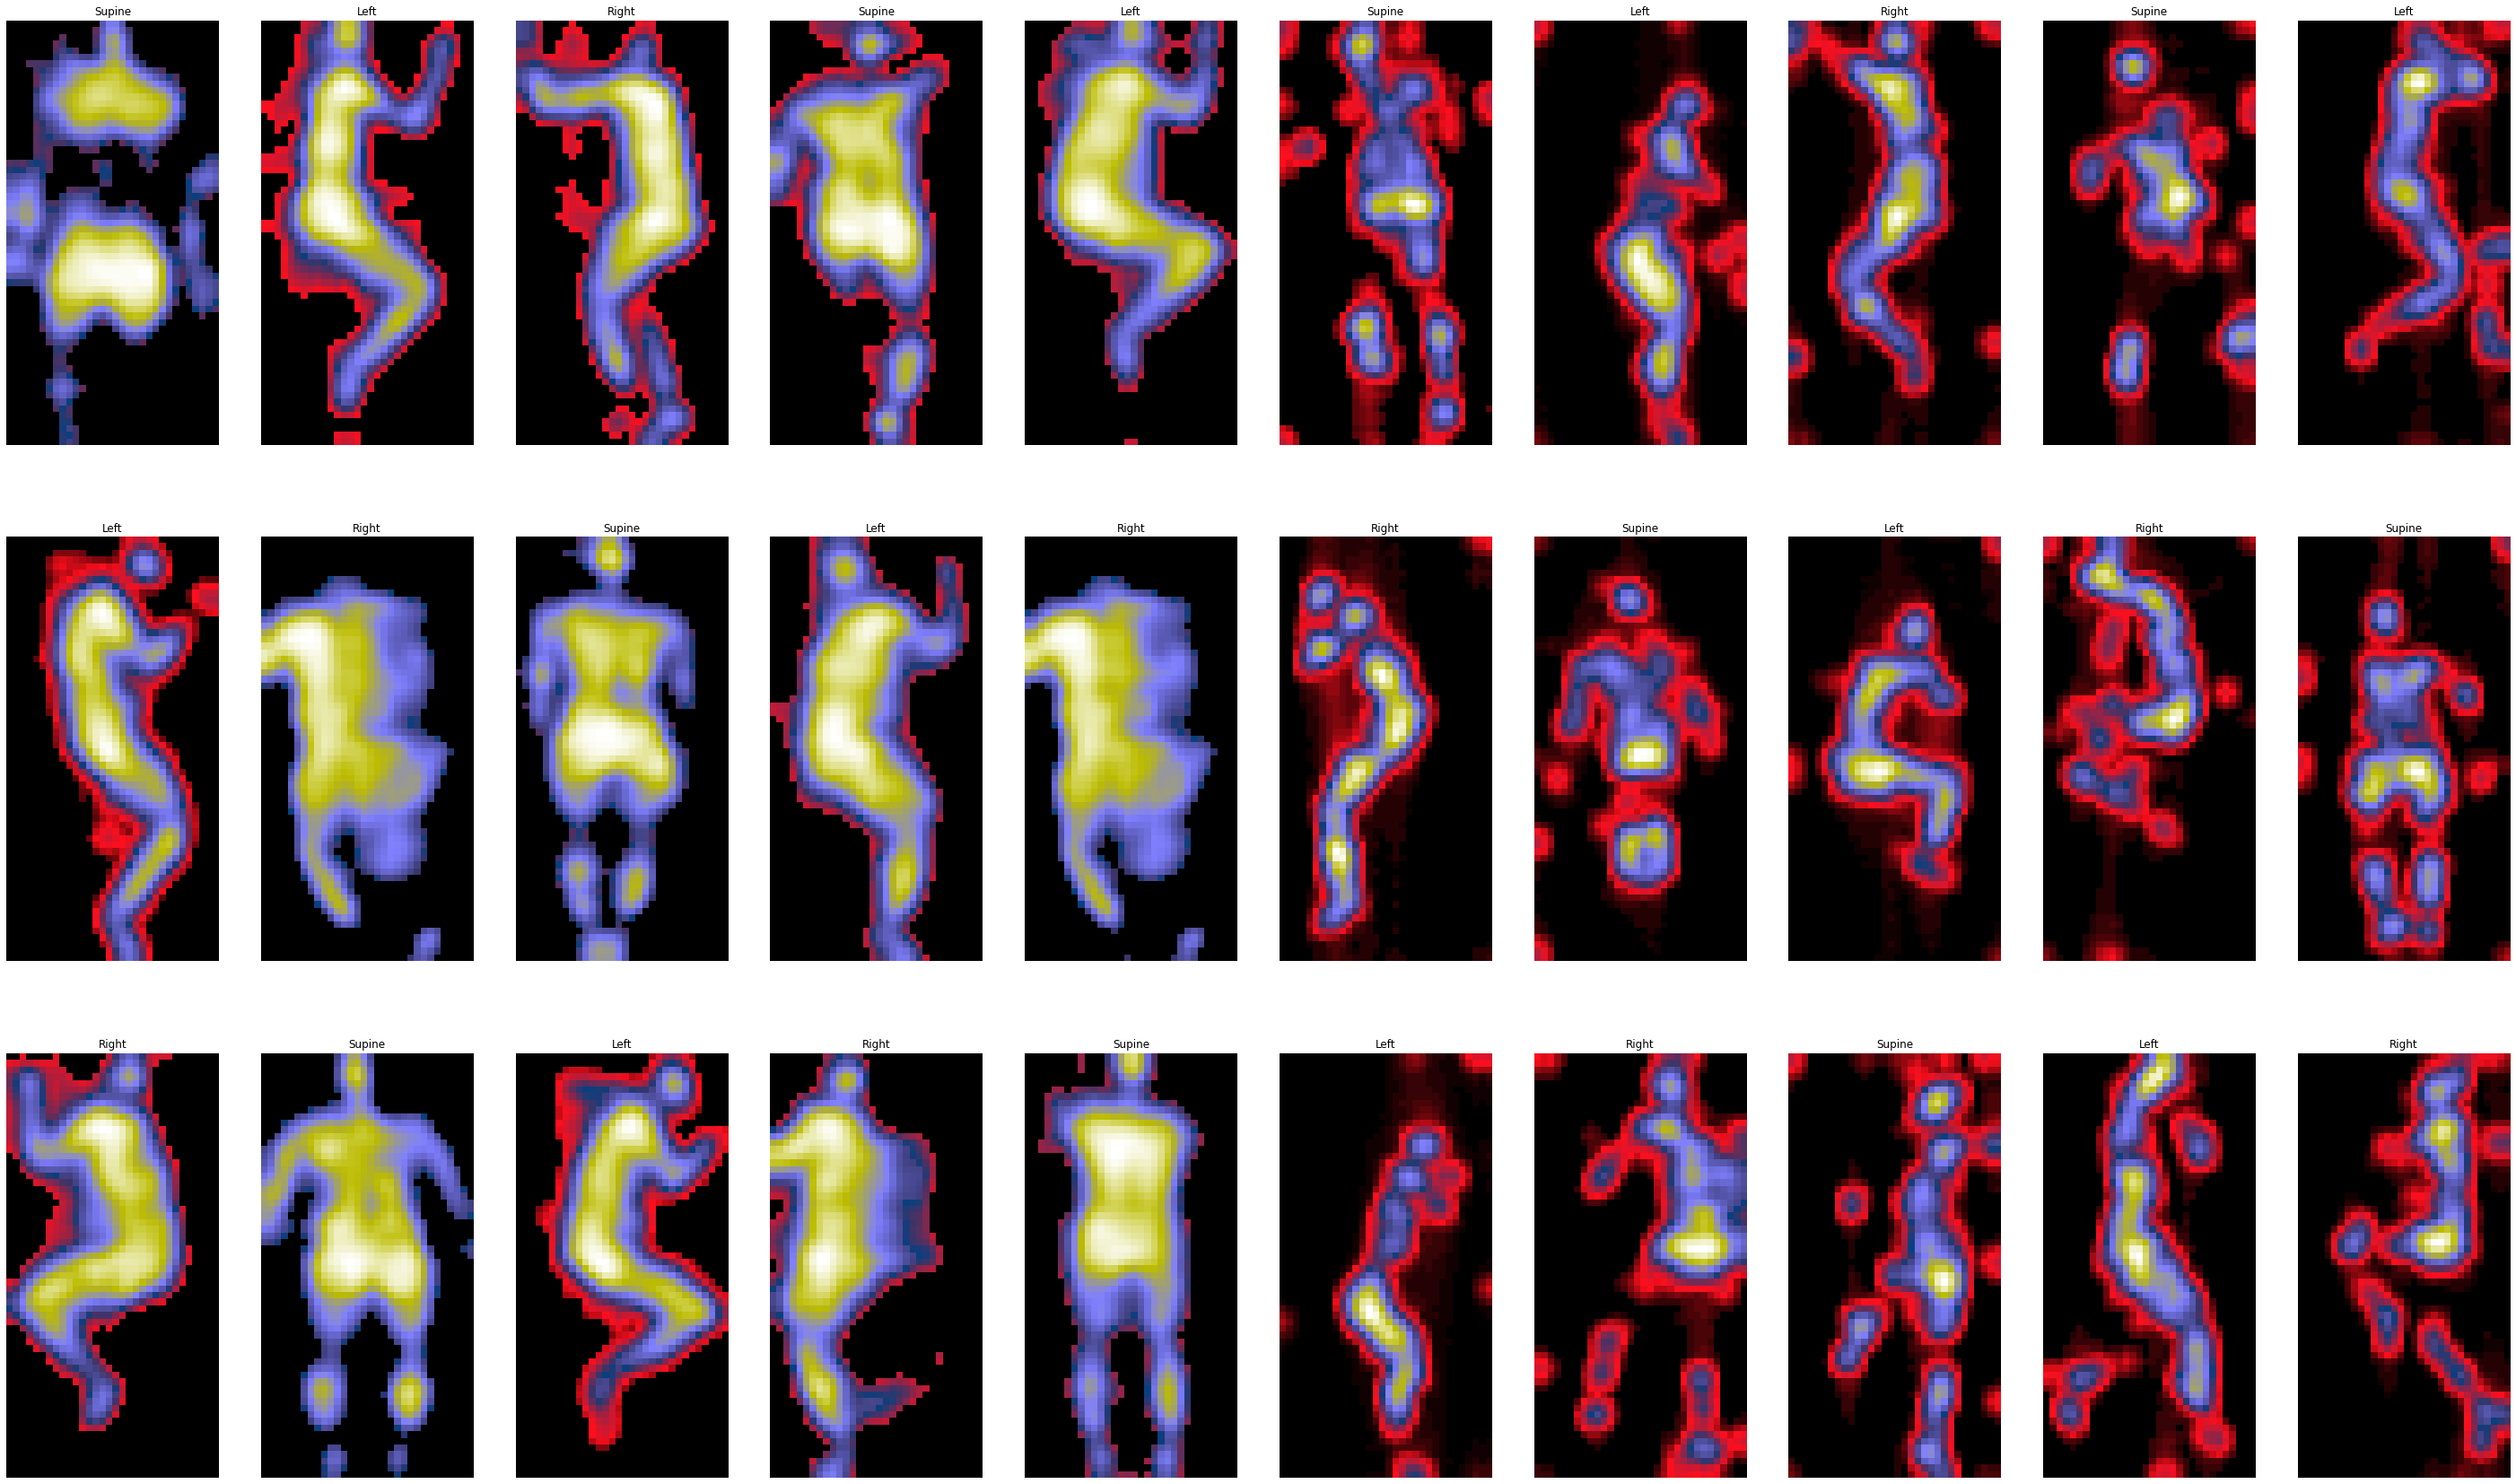

In [14]:
plot_samples(
    samples,
    ncols=10,
    transform=torchvision.transforms.Compose(
        [
            *normalizations,
            Denoise(),
            Blur((3, 3)),
            HighPass(rad=50),
            Blur((3, 3)),
            Threshold(lambda img: np.median(img[img > 0.0])),
            # Blur((3, 3)),
            # Threshold(lambda img: np.median(img[img > 0.0])),
        ]
    ),
)


### Denoising (-> Comparison)

Notes

- Just doing threshold for denoising removes the loose contact between the legs
- Trying out low-/high-pass filter didnt really improve the image, might have to try out some other fourier transforms
- using a denoising function from cv2 still leaves low-value artifacts in the image but does a fairly good job at removing outliers
  - this can be tweaked with many parameters, which might have to be chosen for each image independently
- Using threshold on the outcome of that left the legs more intact than directly theresholding, which is good
- so the cv2 function basically lowered the pixel values of noise pixels which is why we can use a lower threshold then to remove that without breaking the legs


-> medianBlur blurs extremities which disappear in the thresholding step afterwards. MeansDenoising keeps thin structures like the arms ans blurs noise on a big area with low values which is easy to remove with thresholding. Bilateral seems to surround everything with a shadow but thus also highlights noise pixels which dont get removed easily in the thresholding

254 0 uint8


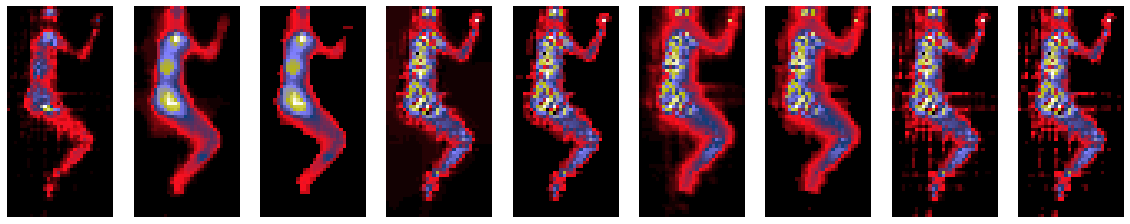

In [50]:
import cv2

image = samples[1][0]
img = np.uint8(image)
denoised_means = cv2.fastNlMeansDenoising(img, None, 9, 7, 21)
denoised_bil = restoration.denoise_bilateral(img)
denoised_wave = restoration.denoise_wavelet(img)
print(np.min(denoised_means), np.max(denoised_means), denoised_means.dtype)
threshold = torchvision.transforms.Compose(
    [
        Threshold(lambda i: np.median(i[i>0])),
    ]
)

image_row(
    image,
    cv2.medianBlur(image, 5),
    threshold((cv2.medianBlur(image, 5), 0))[0],
    denoised_means,
    threshold((denoised_means, 0))[0],
    denoised_bil,
    threshold((denoised_bil, 0))[0],
    denoised_wave,
    threshold((denoised_wave, 0))[0],
    figsize=(20, 10)
)


Bei so unterschiedlichen Rohbildern müsste man eventuell auf den Datensätzen andere Verarbeitungsalgorithmen anwenden -> Daran erkennt man wieder, dass die Preprocessing schritte sehr stark von den eingaben abhängen  
Einmal auch zeigen was bei gleichen Transformationen rauskommen würde


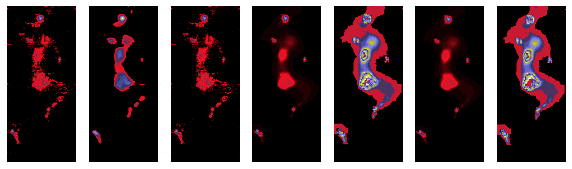

In [32]:
import cv2

image = slp_samples[0][0]
img = np.uint8(image)
denoised = cv2.fastNlMeansDenoising(img, None, 9, 7, 21)
denoised_thr = torchvision.transforms.Compose(
    [
        Threshold(lambda i: np.median(i)),
        # Blur((3, 3)),
        # Threshold(lambda i: np.median(i)),
        Close((1, 4)),
        # Blur((3, 3)),
    ]
)((denoised, 0))[0]

image_row(
    image,
    cv2.medianBlur(img, 5),
    img,
    denoised,
    denoised * 25,
    denoised_thr,
    denoised_thr * 25,
)


### Hough Lines


(64, 32, 3) 248 0
(64, 32) 255 0
(232, 1, 2)


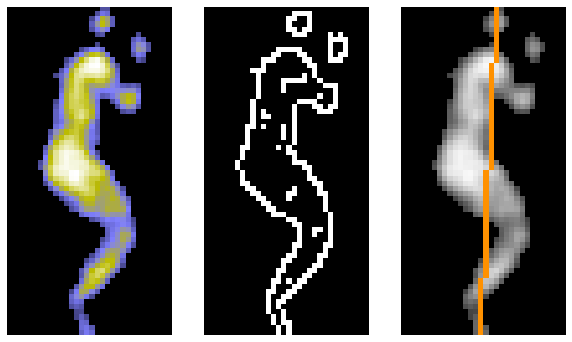

In [217]:
import cv2

transforms_base = [
    *normalizations,
    # Sobel(),
    # Blur((3, 3)),
    # Threshold(lambda img: np.median(img[img > 0.0])),
]

sobel_transform = torchvision.transforms.Compose(transforms_base)

image, __ = sobel_transform(physionet[100])
# image = physionet[0][0]
img = np.uint8(image * 255)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
print(img.shape, np.max(img), np.min(img))
edges = cv2.Canny(img, 100, 200)
print(edges.shape, np.max(edges), np.min(edges))
# lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=10)
threshold = 10
lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold)
if lines is not None:
    # lines = lines.reshape((-1, 2))
    print(lines.shape)
    for rho, theta in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        cv2.line(img, (x1, y1), (x2, y2), (255, 145, 0), 1)


image_row(image, edges, img)


Sobel funktioniert evtl besser als canny weil wir wirklich nur objektumrisse brauchen anstatt noch kanten innerhalb der objekte, die hough dann nur verwirren  
Zeigen was passiert wenn man sobel weglässt -> Alle richtungen werden erkant


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


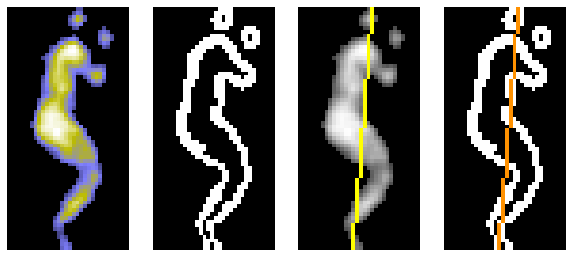

In [71]:
import cv2
import math


image, __ = torchvision.transforms.Compose(
    [
        *normalizations,
        Blur((3, 3)),
        Threshold(lambda img: np.median(img[img > 0.0])),
    ]
)(physionet[100])
lines, sobel = hough_lines(image)

image_row(image, sobel, apply_lines(image, lines), apply_lines(sobel, lines))


#### Dynamic Kernels

Nur Rect Kernel nicht genau genug für Diagonalen?
Selbst mit diagonalen idk -> Experiment
ABER: selten ist eine high-match linie horizontal, also das schonmal useless und selbst diagonal kommt so gut wie nie vor. Ausßerdem sind die personen nicht immer gerade ausgestreckt, welshalb closing in die Richtung auch viel kaputt machen kann (zum beispiel abgeknickter arm wird zu einem großen klotz -> Bildbeweis)


[[0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]]


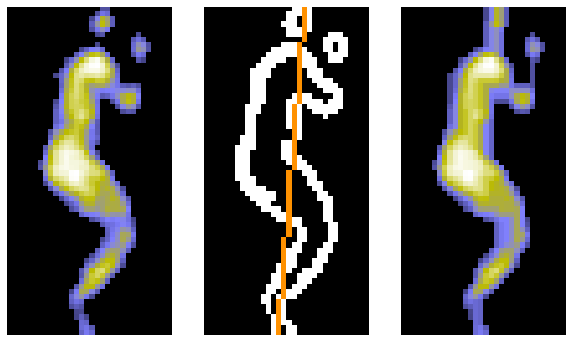

In [67]:
import cv2
import math

image, __ = torchvision.transforms.Compose(
    [
        *normalizations,
        Blur((3, 3)),
        Threshold(lambda img: np.median(img[img > 0.0])),
    ]
)(physionet[100])
lines, sobel = hough_lines(image)

deg = math.degrees(lines[0][1])
print(choose_kernel_ext(deg))
final, __ = torchvision.transforms.Compose(
    [
        *normalizations,
        Blur((3, 3)),
        Threshold(lambda img: np.median(img[img > 0.0])),
        Close(kernel=choose_kernel_ext(deg)),
    ]
)(physionet[100])

image_row(image, apply_lines(sobel, lines), final)


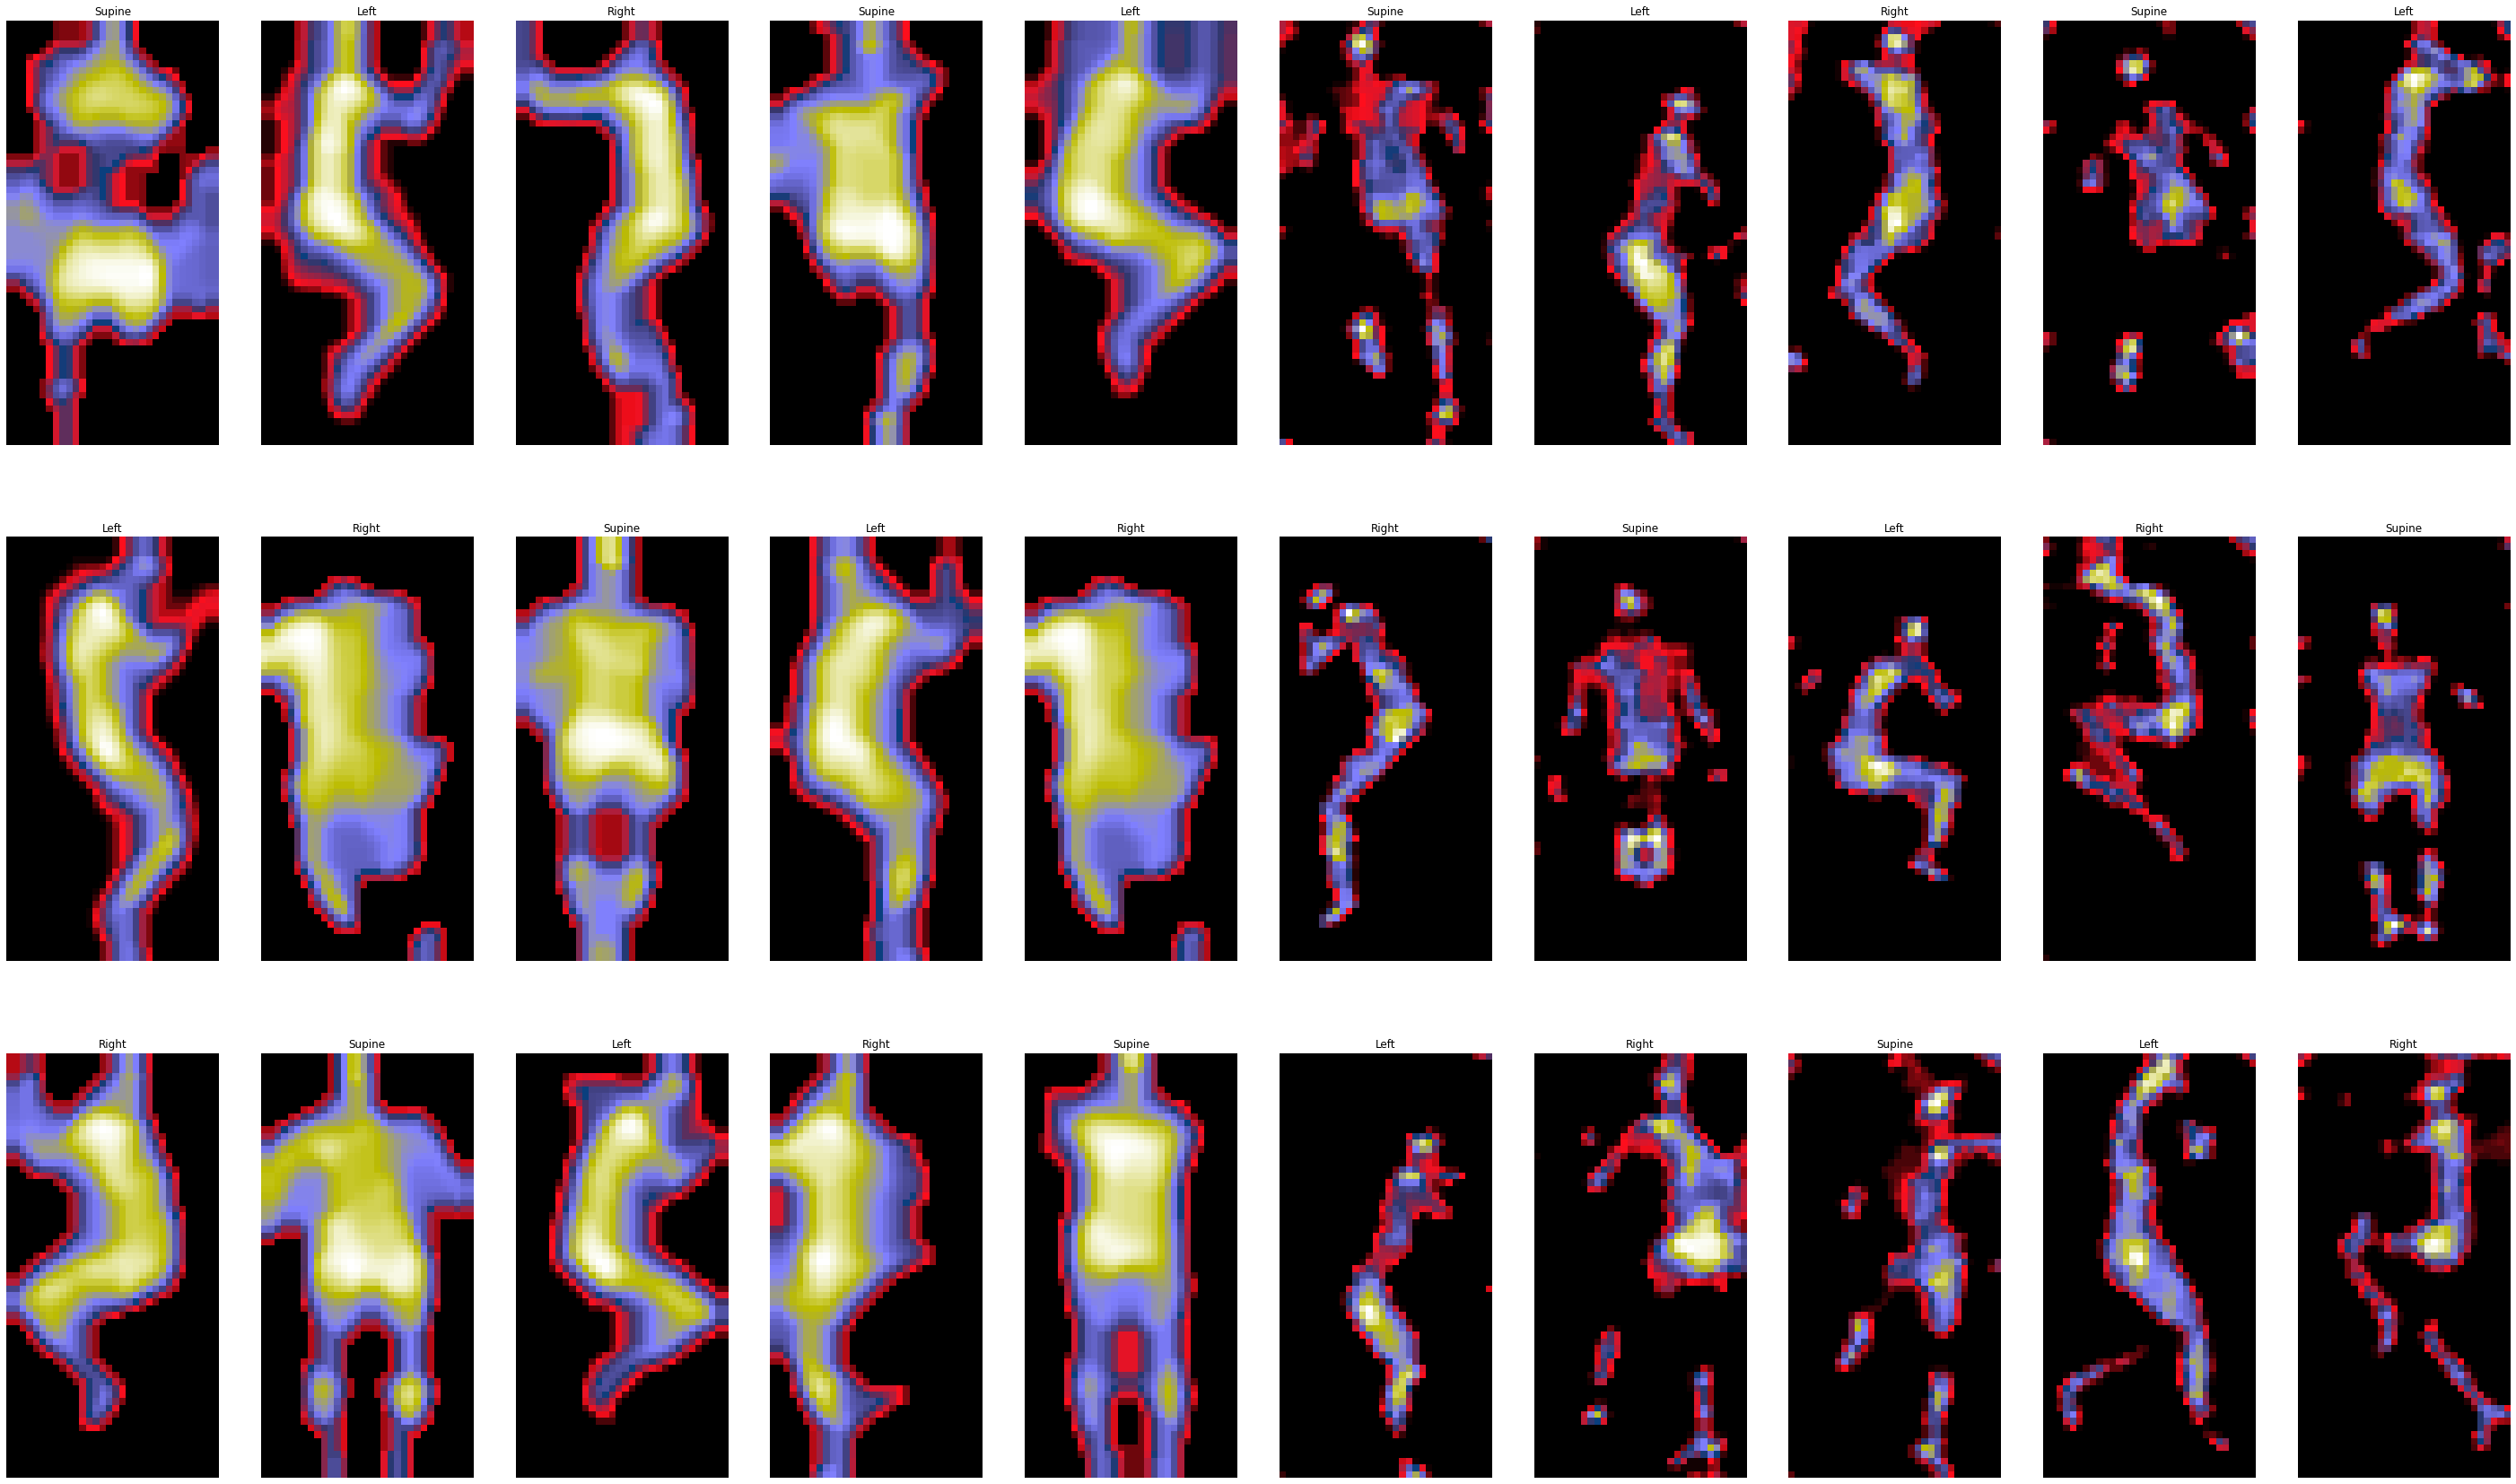

In [72]:
plot_samples(
    samples,
    ncols=10,
    transform=torchvision.transforms.Compose(
        [
            Standardize(),
            NormalizeMinMax(),
            EqualizeHist(),
            Blur((3, 3)),
            Denoise(),
            Threshold(lambda img: np.median(img[img > 0.0])),
            Close((3, 3), ktype=cv2.MORPH_CROSS, iterations=3),
            # Close((3,3), ktype=cv2.MORPH_CROSS, iterations=3),
            Blur((3, 3)),
            CloseInHoughDirection(),
            Resize((32, 64)),
        ]
    ),
)


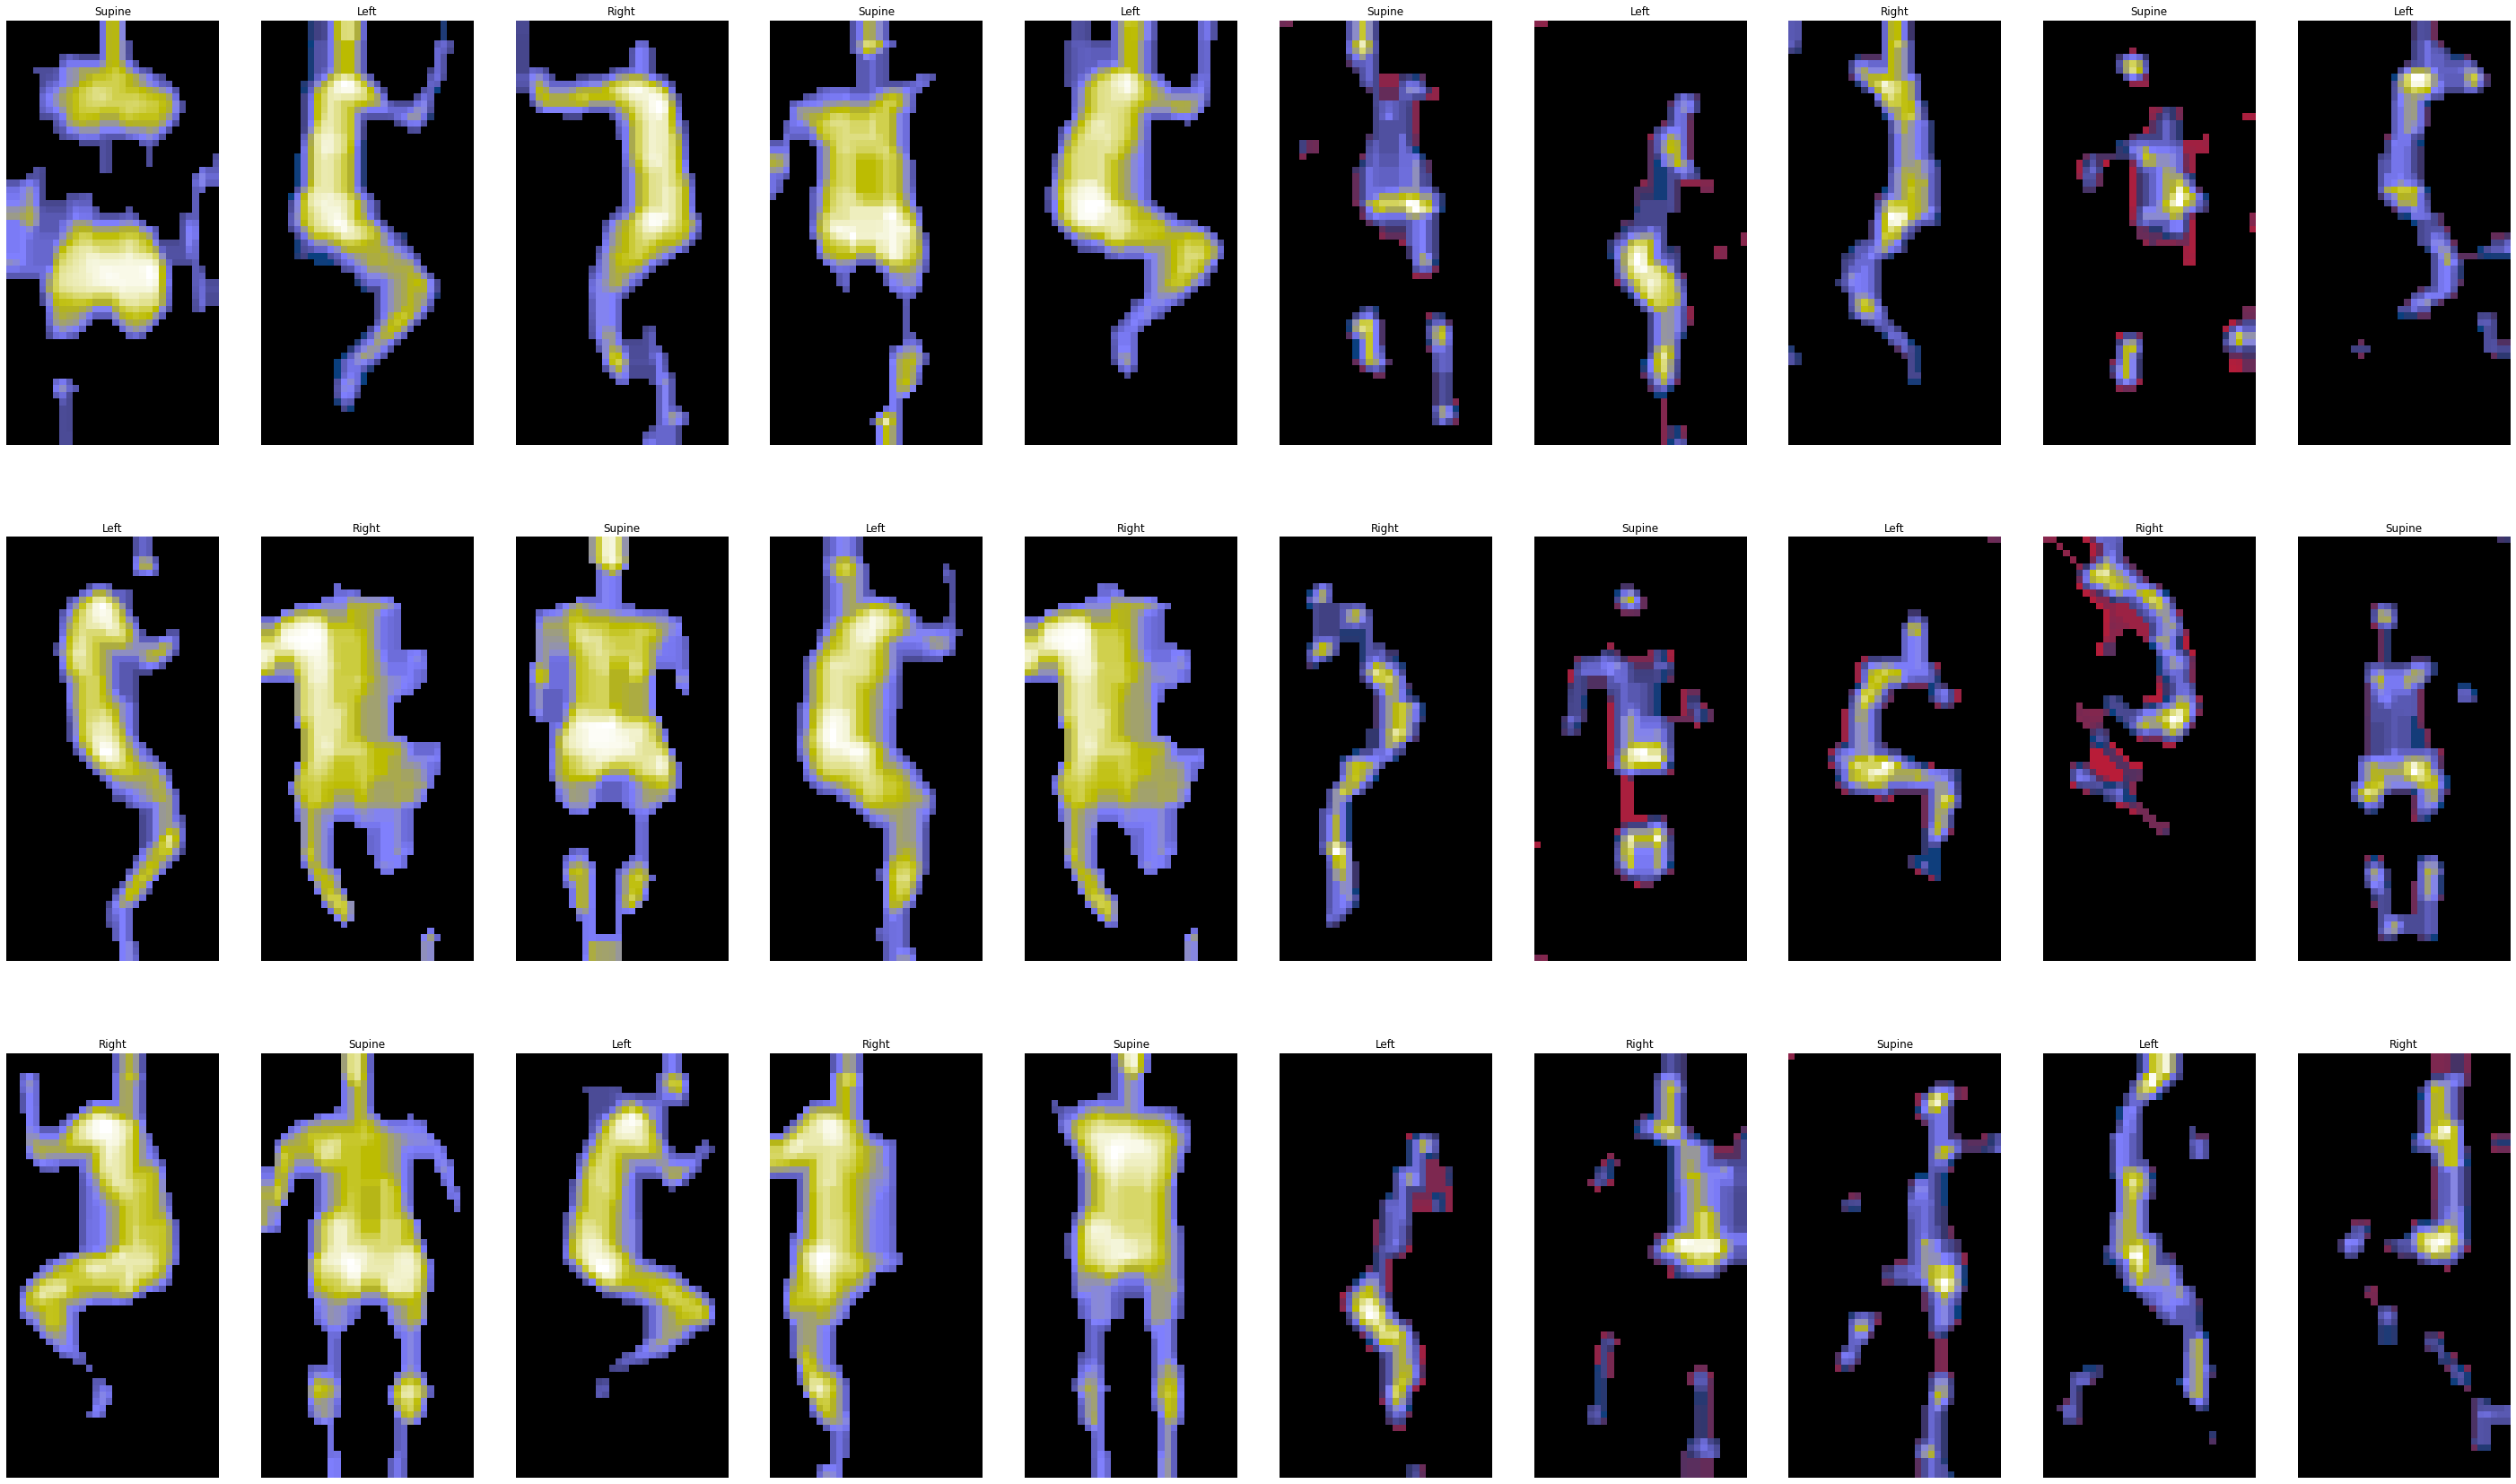

In [73]:
plot_samples(
    samples,
    ncols=10,
    transform=torchvision.transforms.Compose(
        [
            *normalizations,
            Blur((3, 3)),
            Threshold(lambda img: np.median(img[img > 0.0])),
            CloseInHoughDirection(),
        ]
    ),
)


### Pouyan

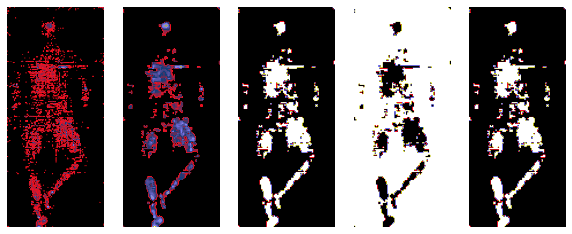

In [102]:
image, label = samples[5]
image = np.uint8(image)
denoised = filters.median(image)
__, binary = cv2.threshold(denoised, np.median(image), 1, cv2.THRESH_BINARY)
inverted = cv2.bitwise_not(binary)
contours, hierarchy = cv2.findContours(inverted, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# for cnt in contours:
    # cv2.drawContours(inverted, [cnt], 0, 1, 3)
with_contours = cv2.bitwise_not(inverted)
cv2.floodFill(binary, None, (0, 0), 1)

image_row(image, denoised, binary, inverted, with_contours)

# plot_samples(
#     samples,
#     ncols=10,
#     transform=torchvision.transforms.Compose(
#         [
#             # *normalizations,
#             PouyanProcessing(),
#         ]
#     ),
# )

Didnt help because segments are not closed but everything is loose pixels

(192, 84)


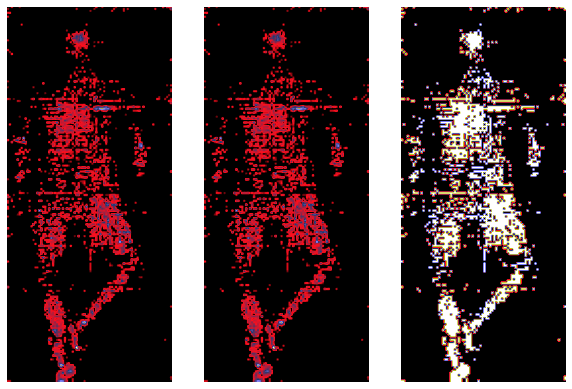

In [117]:
image, label = samples[5]
image = np.uint8(image)
__, binary = 1, image# cv2.threshold(denoised, np.median(image), 1, cv2.THRESH_BINARY)
result = binary.copy()
print(binary.shape)
mask = np.zeros((binary.shape[0]+2, binary.shape[1]+2), np.uint8)
for y, row in enumerate(binary):
    for x, value in enumerate(row):
        if value > 0:
            cv2.floodFill(result, mask, (x, y), 255)
# cv2.floodFill(binary, None, (0, 0), 1)

image_row(image, binary, result)

# plot_samples(
#     samples,
#     ncols=10,
#     transform=torchvision.transforms.Compose(
#         [
#             # *normalizations,
#             PouyanProcessing(),
#         ]
#     ),
# )

### Skimage

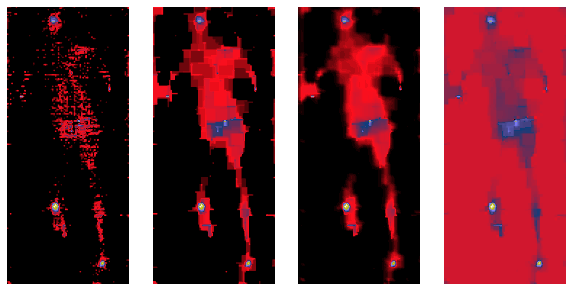

In [40]:
image, label = samples[5]
area_closing = morphology.closing(image, footprint=np.ones((7, 7)))
denoised = restoration.denoise_bilateral(area_closing)
denoised2 = restoration.denoise_wavelet(area_closing)

image_row(image, area_closing, denoised, denoised2)

# plot_samples(
#     samples,
#     ncols=10,
#     transform=torchvision.transforms.Compose(
#         [
#             # *normalizations,
#             PouyanProcessing(),
#         ]
#     ),
# )

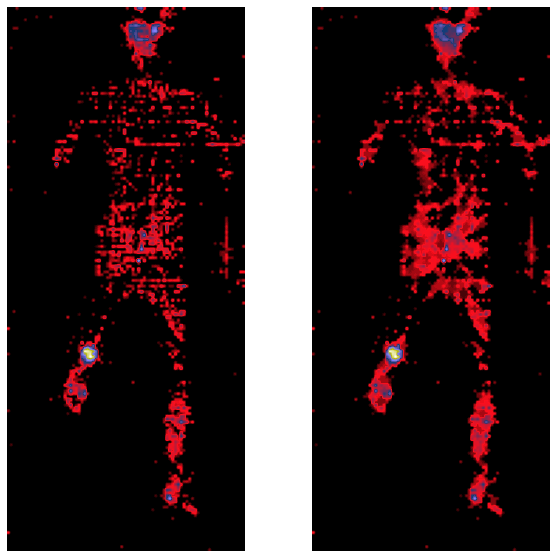

In [ ]:
image, label = samples[5]
area_closing = morphology.closing(image)
area_closing = morphology.closing(image)

image_row(image, area_closing)

# plot_samples(
#     samples,
#     ncols=10,
#     transform=torchvision.transforms.Compose(
#         [
#             # *normalizations,
#             PouyanProcessing(),
#         ]
#     ),
# )

### Warp Polar

0.0 0.9969856 float32
0.0 0.98242396 float32
0.0 0.9887412 float32
0.0 0.9933026 float32
0.0 0.99834853 float32
0.0 0.9811443 float32
0.0 0.9945931 float32
0.0 0.98642087 float32
0.0 0.96723396 float32
0.0 0.9953143 float32
0.0 0.9977792 float32
0.0 0.99705297 float32
0.0 0.9977884 float32
0.0 0.9967884 float32
0.0 0.9964268 float32
0.0 0.8574153 float32
0.0 0.98390025 float32
0.0 0.9651064 float32
0.0 0.980523 float32
0.0 0.9656999 float32
0.0 0.9916682 float32
0.0 0.994213 float32
0.0 0.99644786 float32
0.0 0.9963613 float32
0.0 0.9927712 float32
0.0 0.99249643 float32
0.0 0.9770323 float32
0.0 0.9580889 float32
0.0 0.99028456 float32
0.0 0.9796735 float32


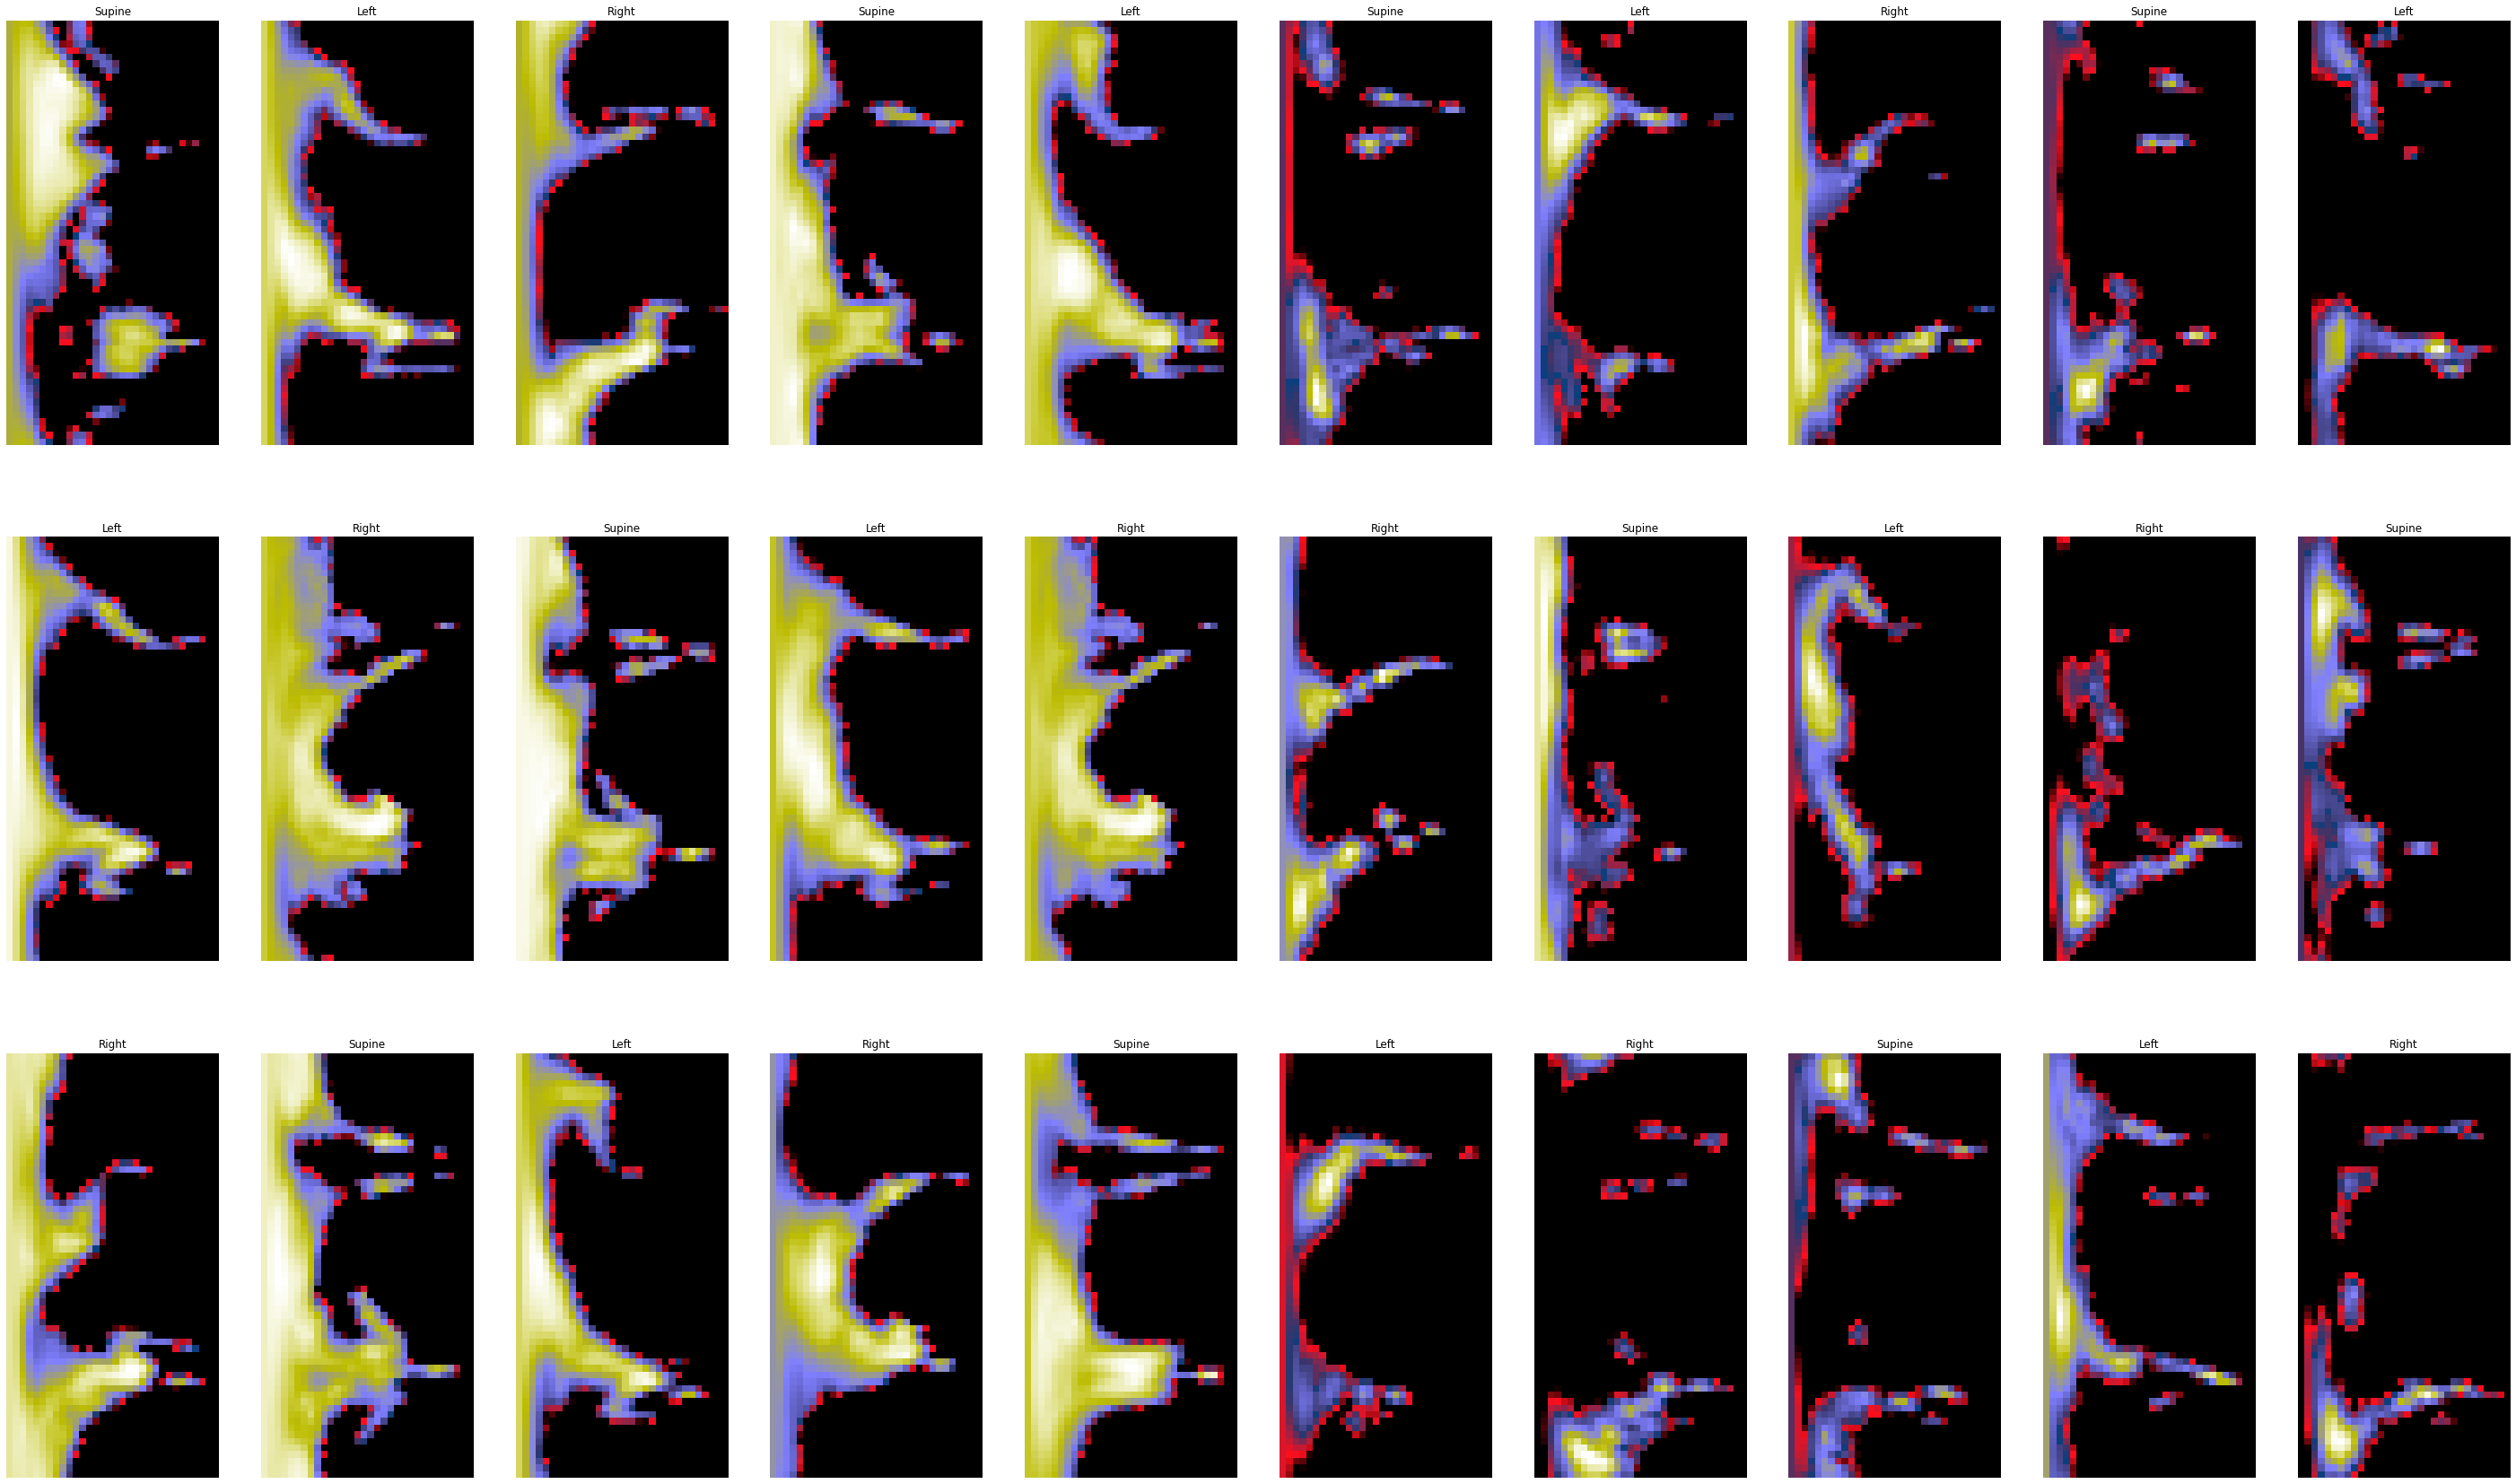

In [60]:
image, label = samples[0]
area_closing = transform.warp_polar(image, output_shape=image.shape)

plot_samples(samples, ncols=10, transform=torchvision.transforms.Compose([
    *normalizations,
    Blur((3, 3)),
    Threshold(lambda img: np.median(img[img > 0.0])),
    WarpPolar(),
]))

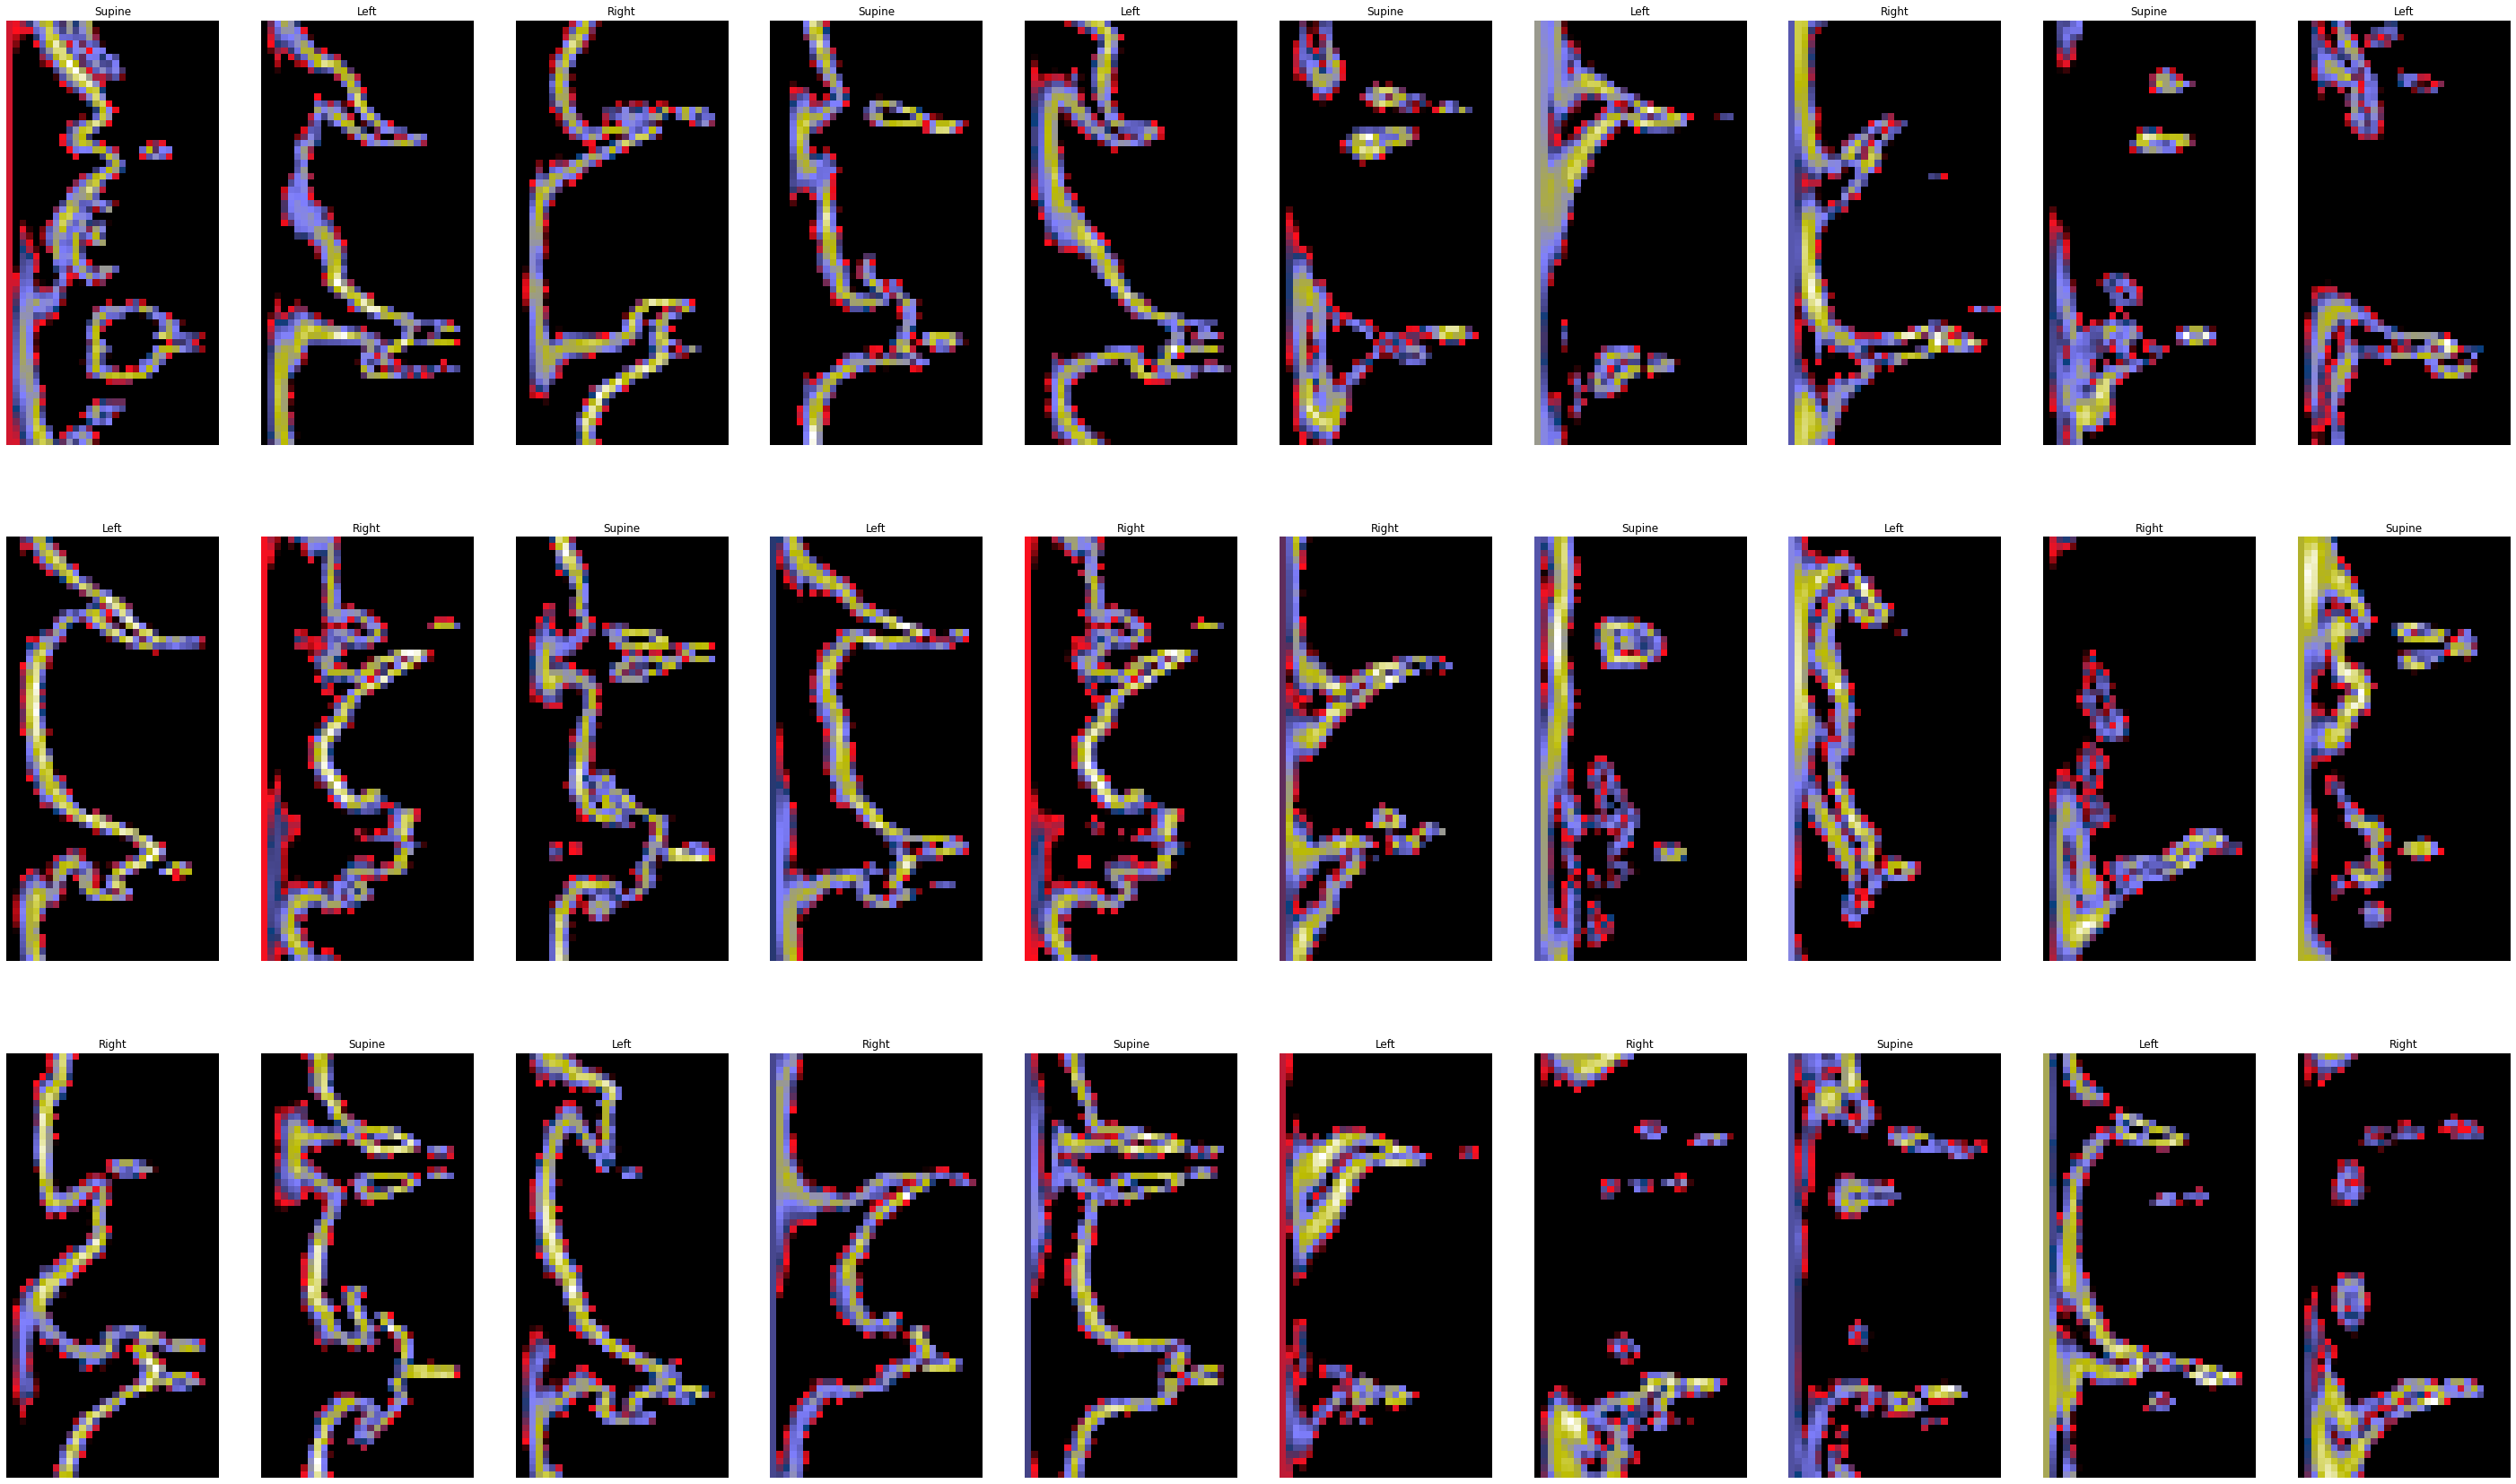

In [ ]:
image, label = samples[0]
area_closing = transform.warp_polar(image, output_shape=image.shape)

plot_samples(samples, ncols=10, transform=torchvision.transforms.Compose([
    *normalizations,
    Blur((3, 3)),
    Threshold(lambda img: np.median(img[img > 0.0])),
    Sobel(),
    Threshold(lambda img: np.median(img[img > 0.0])),
    WarpPolar(),
]))